In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, Conv2D, Conv2DTranspose, BatchNormalization, UpSampling1D, UpSampling2D, Dense, MaxPool2D, LeakyReLU, Reshape, Dropout, Flatten, GaussianNoise, Embedding, multiply, concatenate, add, Lambda
from tensorflow.keras.losses import BinaryCrossentropy, SparseCategoricalCrossentropy, CategoricalCrossentropy, MeanSquaredError
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
import tensorflow as tf

import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import time
import pickle
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from textwrap import wrap

In [3]:
tf.__version__

'2.1.0'

In [4]:
def normalize_img(img):
    return (img - 127.5)/127.5

def unnormalize_img(img):
    return (img + 1.) / 2.

In [5]:
def load_image_caption_dict():
    caption_dict = None
    with open('./bert/embeddedcaptions.pickle', 'rb') as f:
        return pickle.load(f)
    
caption_dict = load_image_caption_dict()

def load_caption_text_dict():
    caption_dict = None
    with open('./bert/captions.pickle', 'rb') as f:
        return pickle.load(f)
    
caption_text_dict = load_caption_text_dict()

In [6]:
train_imgs = []
train_classes = []
train_captions = []
caption_text = []
ae_captions = []
class_index = 0
import os
for root, dirs, files in os.walk("./CUB_200_2011/CUB_200_2011/images-cleaned-named/", topdown=False):
    print(f'{len(files)} samples in class {class_index}, ({root})')
    for name in files:
        train_imgs.append(cv2.cvtColor(cv2.imread(os.path.join(root, name)), cv2.COLOR_RGB2BGR))
        train_classes.append(class_index)
        train_captions.append(caption_dict[name.split('.')[0]+'.txt'][0]) # Just using the first of 10 captions for now
        caption_text.append(caption_text_dict[name.split('.')[0]+'.txt'][0]) # Just using the first of 10 captions for now
        ae_captions.extend(caption_text_dict[name.split('.')[0]+'.txt'])
    class_index += 1
train_imgs = np.array(train_imgs)
train_imgs = (train_imgs - 127.5)/127.5
train_imgs = train_imgs.astype(np.float32)
train_classes = np.array(train_classes)
train_captions = np.array(train_captions)

60 samples in class 0, (./CUB_200_2011/CUB_200_2011/images-cleaned-named/001.Black_footed_Albatross)
60 samples in class 1, (./CUB_200_2011/CUB_200_2011/images-cleaned-named/002.Laysan_Albatross)
58 samples in class 2, (./CUB_200_2011/CUB_200_2011/images-cleaned-named/003.Sooty_Albatross)
60 samples in class 3, (./CUB_200_2011/CUB_200_2011/images-cleaned-named/004.Groove_billed_Ani)
44 samples in class 4, (./CUB_200_2011/CUB_200_2011/images-cleaned-named/005.Crested_Auklet)
41 samples in class 5, (./CUB_200_2011/CUB_200_2011/images-cleaned-named/006.Least_Auklet)
53 samples in class 6, (./CUB_200_2011/CUB_200_2011/images-cleaned-named/007.Parakeet_Auklet)
48 samples in class 7, (./CUB_200_2011/CUB_200_2011/images-cleaned-named/008.Rhinoceros_Auklet)
59 samples in class 8, (./CUB_200_2011/CUB_200_2011/images-cleaned-named/009.Brewer_Blackbird)
60 samples in class 9, (./CUB_200_2011/CUB_200_2011/images-cleaned-named/010.Red_winged_Blackbird)
60 samples in class 10, (./CUB_200_2011/CUB_20

60 samples in class 93, (./CUB_200_2011/CUB_200_2011/images-cleaned-named/094.White_breasted_Nuthatch)
60 samples in class 94, (./CUB_200_2011/CUB_200_2011/images-cleaned-named/095.Baltimore_Oriole)
60 samples in class 95, (./CUB_200_2011/CUB_200_2011/images-cleaned-named/096.Hooded_Oriole)
59 samples in class 96, (./CUB_200_2011/CUB_200_2011/images-cleaned-named/097.Orchard_Oriole)
60 samples in class 97, (./CUB_200_2011/CUB_200_2011/images-cleaned-named/098.Scott_Oriole)
60 samples in class 98, (./CUB_200_2011/CUB_200_2011/images-cleaned-named/099.Ovenbird)
60 samples in class 99, (./CUB_200_2011/CUB_200_2011/images-cleaned-named/100.Brown_Pelican)
50 samples in class 100, (./CUB_200_2011/CUB_200_2011/images-cleaned-named/101.White_Pelican)
60 samples in class 101, (./CUB_200_2011/CUB_200_2011/images-cleaned-named/102.Western_Wood_Pewee)
60 samples in class 102, (./CUB_200_2011/CUB_200_2011/images-cleaned-named/103.Sayornis)
60 samples in class 103, (./CUB_200_2011/CUB_200_2011/image

60 samples in class 187, (./CUB_200_2011/CUB_200_2011/images-cleaned-named/188.Pileated_Woodpecker)
60 samples in class 188, (./CUB_200_2011/CUB_200_2011/images-cleaned-named/189.Red_bellied_Woodpecker)
58 samples in class 189, (./CUB_200_2011/CUB_200_2011/images-cleaned-named/190.Red_cockaded_Woodpecker)
60 samples in class 190, (./CUB_200_2011/CUB_200_2011/images-cleaned-named/191.Red_headed_Woodpecker)
60 samples in class 191, (./CUB_200_2011/CUB_200_2011/images-cleaned-named/192.Downy_Woodpecker)
60 samples in class 192, (./CUB_200_2011/CUB_200_2011/images-cleaned-named/193.Bewick_Wren)
60 samples in class 193, (./CUB_200_2011/CUB_200_2011/images-cleaned-named/194.Cactus_Wren)
60 samples in class 194, (./CUB_200_2011/CUB_200_2011/images-cleaned-named/195.Carolina_Wren)
59 samples in class 195, (./CUB_200_2011/CUB_200_2011/images-cleaned-named/196.House_Wren)
60 samples in class 196, (./CUB_200_2011/CUB_200_2011/images-cleaned-named/197.Marsh_Wren)
60 samples in class 197, (./CUB_20

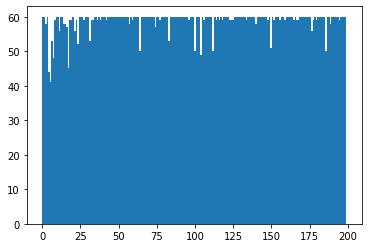

(11788, 64, 64, 3)


In [7]:
plt.hist(train_classes, bins=200)
plt.show()
assert(len(train_imgs) == len(train_classes))
print(train_imgs.shape)

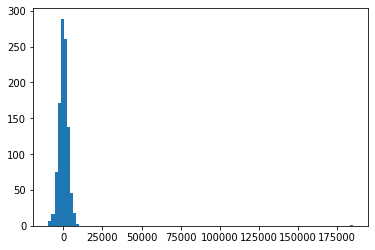

929
18.448483


In [8]:
plt.hist(np.sum(train_captions, axis=0), bins=100)
plt.show()
print(np.argmax(np.sum(train_captions, axis=0)))
print(train_captions[2786][929])

In [9]:
def create_simple_attrs(attrs):
    # Structure is like so: [0-14:color, 15-19:size, 20-33:shape]

    simple_attrs = np.zeros((attrs.shape[0], 34))
    
    # Color
    simple_attrs[:, 0:15] = attrs[:, 248:263]
    
    # Size and shape
    simple_attrs[:, 15:34] = attrs[:, 217:236]
    
    return simple_attrs


In [10]:
def create_even_simpler_attrs(attrs):
    # Structure is like so: [0-4:color, 5-7:size, 8-9:shape]
    
    simplest_attrs = np.zeros((attrs.shape[0], 10))
    
    simplest_attrs[:, 0] = attrs[:, 1] # Brown
    simplest_attrs[:, 1] = attrs[:, 5] # Grey
    simplest_attrs[:, 2] = attrs[:, 11] # Black
    simplest_attrs[:, 3] = attrs[:, 12] # White
    simplest_attrs[:, 4] = np.clip(np.sum(attrs[:, [0, 2, 3, 4, 6, 7, 8, 9, 10, 13, 14]], axis=1), a_min=0, a_max=1) # Other
    
    simplest_attrs[:, 5] = attrs[:, 19] # Smallest
    simplest_attrs[:, 6] = attrs[:, 16] # Small
    simplest_attrs[:, 7] = np.clip(np.sum(attrs[:, [15, 17, 18]], axis=1), a_min=0, a_max=1) # Large
    
    simplest_attrs[:, 8] = attrs[:, 33] # Perching-like
    simplest_attrs[:, 9] = np.clip(np.sum(attrs[:, [20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]], axis=1), a_min=0, a_max=1) # Not perching-like
    
    return simplest_attrs

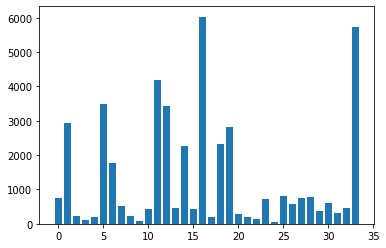

In [11]:
def load_image_attributes():
    train_attrs = np.zeros((train_imgs.shape[0], 312))
    with open('./CUB_200_2011/CUB_200_2011/attributes/image_attribute_labels.txt', 'r') as f:
        lines = f.readlines()
        for line in lines:
            
            # For now we don't care about attribute certainty, just if it is present.
            try:
                split = line.split()
                img_id = int(split[0])
                assert(img_id > 0)
                assert(img_id <= 11788)
                attr_id = int(split[1])
                assert(attr_id > 0)
                assert(attr_id <= 312)
                is_present = int(split[2])
                assert(is_present == 0 or is_present == 1)
            except: 
                print(line)
                print(line.split())
                return
            
            train_attrs[img_id-1, attr_id-1] = is_present
    return train_attrs

train_attrs = load_image_attributes().astype('float32')
train_attrs = create_simple_attrs(train_attrs)
plt.bar([x for x in range(34)], np.sum(train_attrs, axis=0))
plt.show()
# train_attrs = create_even_simpler_attrs(train_attrs)
train_attrs = train_attrs.astype(np.float32)

In [12]:
def get_attr_weights(attrs):
    sum_attrs = np.sum(attrs, axis=0)
    max_freq = np.max(sum_attrs)
    scalars = max_freq * (1. / sum_attrs)
    norm_scalars = scalars / np.mean(scalars)
    return norm_scalars

train_attr_weights = get_attr_weights(train_attrs)
print(train_attr_weights)

[0.4243079  0.10723    1.4030449  3.2212765  1.6272428  0.09058396
 0.17775063 0.6153706  1.3785377  3.8498182  0.7174661  0.07534251
 0.09230559 0.68627197 0.1394985  0.7445404  0.05235242 1.5032625
 0.13636506 0.11238346 1.1479459  1.5250489  2.4098098  0.43663225
 6.442553   0.383113   0.5341542  0.42717874 0.40628713 0.8648907
 0.53056324 0.986516   0.6953416  0.05501657]


In [61]:
def make_caption_autoencoder(attribute_shape):
    droprate = 0.3
    
    caption_shape = 1024
    captions_in = Input(shape=(caption_shape))
    
    x = Reshape((caption_shape, 1))(captions_in)
    
    x = Conv1D(32, 3, strides=2, padding='same')(x)
    x = LeakyReLU()(x)
    x = Dropout(droprate)(x)
    
    x = Conv1D(64, 3, strides=2, padding='same')(x)
    x = LeakyReLU()(x)
    x = Dropout(droprate)(x)
    
    x = Conv1D(128, 3, strides=2, padding='same')(x)
    x = LeakyReLU()(x)
    x = Dropout(droprate)(x)
    
    x = Conv1D(256, 3, strides=2, padding='same')(x)
    x = LeakyReLU()(x)    
    x = Flatten()(x)
    
    x = Dropout(droprate)(x)
    
    x = Dense(attribute_shape, name='attr_out', activation='sigmoid')(x)
    attr_out = x
    
    x = Dense(16384)(x)
    x = LeakyReLU()(x)
    x = Dropout(droprate)(x)
    
    x = Reshape((64, 256))(x)

    x = UpSampling1D()(x)
    x = Conv1D(256, 3, strides=1, padding='same')(x)
    x = LeakyReLU()(x)
    x = Dropout(droprate)(x)
    
    x = UpSampling1D()(x)
    x = Conv1D(128, 3, strides=1, padding='same')(x)
    x = LeakyReLU()(x)
    x = Dropout(droprate)(x)
    
    x = UpSampling1D()(x)
    x = Conv1D(64, 3, strides=1, padding='same')(x)
    x = LeakyReLU()(x)
    x = Dropout(droprate)(x)

    x = UpSampling1D()(x)
    x = Conv1D(32, 3, strides=1, padding='same')(x)
    x = LeakyReLU()(x)
    x = Dropout(droprate)(x)
    
    x = Conv1D(1, 3, strides=1, padding='same')(x)
    x = LeakyReLU()(x)
    
    x = Flatten(name='caption_out')(x)
    
#     x = Dense(1024, name='caption_out')(x)
    
    return Model(captions_in, [x, attr_out])

In [62]:
autoencoder = make_caption_autoencoder(34)
autoencoder.summary()

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 1024)]            0         
_________________________________________________________________
reshape_30 (Reshape)         (None, 1024, 1)           0         
_________________________________________________________________
conv1d_109 (Conv1D)          (None, 512, 64)           256       
_________________________________________________________________
leaky_re_lu_124 (LeakyReLU)  (None, 512, 64)           0         
_________________________________________________________________
conv1d_110 (Conv1D)          (None, 256, 128)          24704     
_________________________________________________________________
leaky_re_lu_125 (LeakyReLU)  (None, 256, 128)          0         
_________________________________________________________________
conv1d_111 (Conv1D)          (None, 128, 256)          985

In [51]:
def get_weighted_loss(weights):
    def weighted_loss(y_true, y_pred):
        return K.mean(weights*K.binary_crossentropy(y_true, y_pred), axis=-1)
    return weighted_loss

losses = {
    'caption_out': 'mse',
    'attr_out': get_weighted_loss(train_attr_weights),
}

lossWeights = {'caption_out': 1.0, 'attr_out': 1.0}

autoencoder.compile(optimizer = Adam(0.0001),
                    loss = losses,
                    loss_weights = lossWeights)

# c_train, c_test, a_train, a_test = train_test_split(train_captions, train_attrs, test_size=0.2)

newhistory = autoencoder.fit(train_captions,
                {'caption_out' : train_captions, 'attr_out' : train_attrs},
#                 class_weight={'caption_out' : None, 'attr_out' : train_attr_weights},
#                 validation_data=(c_test, [c_test, a_test]),
                validation_split=0.2,
                epochs=200,
                batch_size=32)

Train on 9430 samples, validate on 2358 samples
Epoch 1/200
9430/9430 [==============================] - 10s 1ms/sample - loss: 0.3049 - caption_out_loss: 0.1487 - attr_out_loss: 0.1561 - val_loss: 0.1301 - val_caption_out_loss: 0.0524 - val_attr_out_loss: 0.0777
Epoch 2/200
9430/9430 [==============================] - 6s 675us/sample - loss: 0.1745 - caption_out_loss: 0.0617 - attr_out_loss: 0.1128 - val_loss: 0.1185 - val_caption_out_loss: 0.0414 - val_attr_out_loss: 0.0771
Epoch 3/200
9430/9430 [==============================] - 6s 673us/sample - loss: 0.1637 - caption_out_loss: 0.0514 - attr_out_loss: 0.1124 - val_loss: 0.1057 - val_caption_out_loss: 0.0315 - val_attr_out_loss: 0.0741
Epoch 4/200
9430/9430 [==============================] - 6s 675us/sample - loss: 0.1561 - caption_out_loss: 0.0440 - attr_out_loss: 0.1120 - val_loss: 0.1041 - val_caption_out_loss: 0.0262 - val_attr_out_loss: 0.0779
Epoch 5/200
9430/9430 [==============================] - 6s 677us/sample - loss: 0.15

9430/9430 [==============================] - 7s 691us/sample - loss: 0.1230 - caption_out_loss: 0.0236 - attr_out_loss: 0.0994 - val_loss: 0.0823 - val_caption_out_loss: 0.0115 - val_attr_out_loss: 0.0707
Epoch 39/200
9430/9430 [==============================] - 7s 695us/sample - loss: 0.1227 - caption_out_loss: 0.0235 - attr_out_loss: 0.0992 - val_loss: 0.0806 - val_caption_out_loss: 0.0114 - val_attr_out_loss: 0.0691
Epoch 40/200
9430/9430 [==============================] - 7s 691us/sample - loss: 0.1223 - caption_out_loss: 0.0234 - attr_out_loss: 0.0988 - val_loss: 0.0822 - val_caption_out_loss: 0.0113 - val_attr_out_loss: 0.0708
Epoch 41/200
9430/9430 [==============================] - 7s 692us/sample - loss: 0.1223 - caption_out_loss: 0.0233 - attr_out_loss: 0.0989 - val_loss: 0.0814 - val_caption_out_loss: 0.0112 - val_attr_out_loss: 0.0701
Epoch 42/200
9430/9430 [==============================] - 7s 697us/sample - loss: 0.1219 - caption_out_loss: 0.0234 - attr_out_loss: 0.0985 -

9430/9430 [==============================] - 7s 693us/sample - loss: 0.1160 - caption_out_loss: 0.0221 - attr_out_loss: 0.0939 - val_loss: 0.0789 - val_caption_out_loss: 0.0106 - val_attr_out_loss: 0.0682
Epoch 76/200
9430/9430 [==============================] - 7s 695us/sample - loss: 0.1156 - caption_out_loss: 0.0221 - attr_out_loss: 0.0935 - val_loss: 0.0803 - val_caption_out_loss: 0.0112 - val_attr_out_loss: 0.0690
Epoch 77/200
9430/9430 [==============================] - 7s 693us/sample - loss: 0.1156 - caption_out_loss: 0.0221 - attr_out_loss: 0.0936 - val_loss: 0.0807 - val_caption_out_loss: 0.0107 - val_attr_out_loss: 0.0699
Epoch 78/200
9430/9430 [==============================] - 7s 693us/sample - loss: 0.1150 - caption_out_loss: 0.0221 - attr_out_loss: 0.0930 - val_loss: 0.0794 - val_caption_out_loss: 0.0106 - val_attr_out_loss: 0.0687
Epoch 79/200
9430/9430 [==============================] - 7s 693us/sample - loss: 0.1155 - caption_out_loss: 0.0220 - attr_out_loss: 0.0935 -

9430/9430 [==============================] - 7s 694us/sample - loss: 0.1110 - caption_out_loss: 0.0216 - attr_out_loss: 0.0893 - val_loss: 0.0812 - val_caption_out_loss: 0.0109 - val_attr_out_loss: 0.0702
Epoch 113/200
9430/9430 [==============================] - 7s 716us/sample - loss: 0.1108 - caption_out_loss: 0.0216 - attr_out_loss: 0.0892 - val_loss: 0.0816 - val_caption_out_loss: 0.0109 - val_attr_out_loss: 0.0706
Epoch 114/200
9430/9430 [==============================] - 7s 710us/sample - loss: 0.1110 - caption_out_loss: 0.0217 - attr_out_loss: 0.0893 - val_loss: 0.0803 - val_caption_out_loss: 0.0110 - val_attr_out_loss: 0.0692
Epoch 115/200
9430/9430 [==============================] - 7s 732us/sample - loss: 0.1105 - caption_out_loss: 0.0216 - attr_out_loss: 0.0890 - val_loss: 0.0813 - val_caption_out_loss: 0.0110 - val_attr_out_loss: 0.0702
Epoch 116/200
9430/9430 [==============================] - 7s 734us/sample - loss: 0.1109 - caption_out_loss: 0.0217 - attr_out_loss: 0.08

9430/9430 [==============================] - 7s 711us/sample - loss: 0.1076 - caption_out_loss: 0.0214 - attr_out_loss: 0.0863 - val_loss: 0.0810 - val_caption_out_loss: 0.0107 - val_attr_out_loss: 0.0702
Epoch 150/200
9430/9430 [==============================] - 7s 701us/sample - loss: 0.1074 - caption_out_loss: 0.0214 - attr_out_loss: 0.0860 - val_loss: 0.0821 - val_caption_out_loss: 0.0106 - val_attr_out_loss: 0.0714
Epoch 151/200
9430/9430 [==============================] - 7s 696us/sample - loss: 0.1079 - caption_out_loss: 0.0214 - attr_out_loss: 0.0865 - val_loss: 0.0821 - val_caption_out_loss: 0.0107 - val_attr_out_loss: 0.0712
Epoch 152/200
9430/9430 [==============================] - 7s 712us/sample - loss: 0.1071 - caption_out_loss: 0.0213 - attr_out_loss: 0.0858 - val_loss: 0.0825 - val_caption_out_loss: 0.0104 - val_attr_out_loss: 0.0720
Epoch 153/200
9430/9430 [==============================] - 7s 702us/sample - loss: 0.1070 - caption_out_loss: 0.0213 - attr_out_loss: 0.08

9430/9430 [==============================] - 7s 703us/sample - loss: 0.1050 - caption_out_loss: 0.0212 - attr_out_loss: 0.0838 - val_loss: 0.0801 - val_caption_out_loss: 0.0105 - val_attr_out_loss: 0.0695
Epoch 187/200
9430/9430 [==============================] - 7s 740us/sample - loss: 0.1045 - caption_out_loss: 0.0211 - attr_out_loss: 0.0834 - val_loss: 0.0821 - val_caption_out_loss: 0.0106 - val_attr_out_loss: 0.0713
Epoch 188/200
9430/9430 [==============================] - 7s 722us/sample - loss: 0.1045 - caption_out_loss: 0.0212 - attr_out_loss: 0.0833 - val_loss: 0.0813 - val_caption_out_loss: 0.0106 - val_attr_out_loss: 0.0706
Epoch 189/200
9430/9430 [==============================] - 7s 721us/sample - loss: 0.1037 - caption_out_loss: 0.0211 - attr_out_loss: 0.0826 - val_loss: 0.0806 - val_caption_out_loss: 0.0103 - val_attr_out_loss: 0.0702
Epoch 190/200
9430/9430 [==============================] - 7s 731us/sample - loss: 0.1041 - caption_out_loss: 0.0211 - attr_out_loss: 0.08

In [179]:
flat_hist_c.extend(newhistory.history['caption_out_loss'])
flat_hist_a.extend(newhistory.history['attr_out_loss'])

# flat_hist_c = []
# for sublist in history.history['caption_out_loss']:
#     if not isinstance(sublist, list):
#         flat_hist_c.append(sublist)
#         continue
#     for item in sublist:
#         flat_hist_c.append(item)
        
# flat_hist_a = []
# for sublist in history.history['attr_out_loss']:
#     if not isinstance(sublist, list):
#         flat_hist_a.append(sublist)
#         continue
#     for item in sublist:
#         flat_hist_a.append(item)

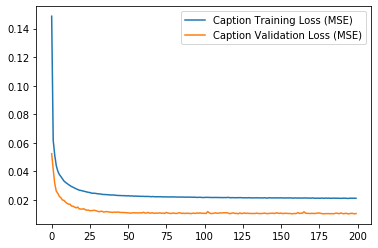

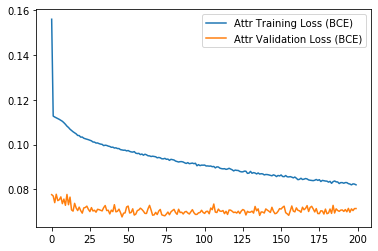

In [52]:
plot_save_dir = 'bird-gan-attributes-split-captions-concat-caption-loss-autoencoder-34-weighted'

# Val loss is lower because dropout isn't active during testing
# https://keras.io/getting_started/faq/#why-is-my-training-loss-much-higher-than-my-testing-loss

plt.plot(newhistory.history['caption_out_loss'], label="Caption Training Loss (MSE)")
plt.plot(newhistory.history['val_caption_out_loss'], label="Caption Validation Loss (MSE)")
plt.legend()
# plt.savefig('./results/plots/'+plot_save_dir+'/autoencoder_caption_loss.png')
plt.show()

plt.plot(newhistory.history['attr_out_loss'], label="Attr Training Loss (BCE)")
plt.plot(newhistory.history['val_attr_out_loss'], label="Attr Validation Loss (BCE)")
plt.legend()
# plt.savefig('./results/plots/'+plot_save_dir+'/autoencoder_attr_loss.png')
plt.show()


(11788, 34)
dict_values([311, 600, 19, 13, 7, 266, 608, 51, 34, 3, 4, 2839, 1309, 168, 375, 5, 6622, 30, 822, 349, 14, 4, 47, 126, 7, 104, 27, 1, 0, 6, 5, 4, 4, 5600])


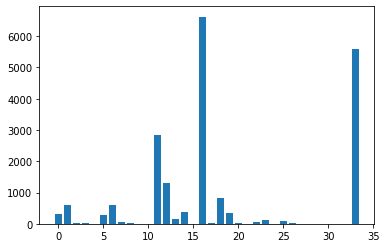

In [122]:
# autoencoder.save_weights('./results/weights/bird-gan-attributes-split-captions-concat-caption-loss-autoencoder-34-weighted/autoencoder-conv1d-1000-val.h5')
# autoencoder.load_weights('./results/weights/bird-gan-attributes-split-captions-concat-caption-loss-autoencoder-34/autoencoder-conv1d-200.h5')

# discriminator_attr.load_weights('./results/weights/bird-gan-attributes-split-captions-concat-caption-loss-autoencoder-34/disc_weights_attributes_split_attr_6000.h5')

d = dict.fromkeys([i for i in range(34)], 0)
prediction = autoencoder.predict(np.array(train_captions))[1]
print(prediction.shape)
prediction = np.round(prediction)
for p in prediction:
    p = np.where(p == 1)
    for i in p[0]:
        d[i] += 1
    
plt.bar([x for x in range(34)], d.values())
print(d.values())

(11788, 34)


<BarContainer object of 34 artists>

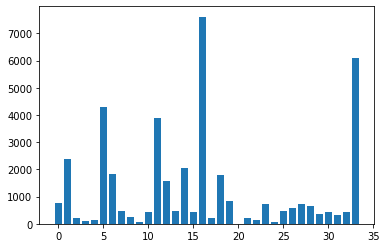

In [16]:
# autoencoder.save_weights('./results/weights/bird-gan-attributes-split-captions-concat-caption-loss-autoencoder-34/autoencoder-conv1d-200.h5')
autoencoder.load_weights('./results/weights/bird-gan-attributes-split-captions-concat-caption-loss-autoencoder-34-weighted/autoencoder-conv1d-1000.h5')

# discriminator_attr.load_weights('./results/weights/bird-gan-attributes-split-captions-concat-caption-loss-autoencoder-34/disc_weights_attributes_split_attr_6000.h5')

d = dict.fromkeys([i for i in range(34)], 0)
prediction = autoencoder.predict(np.array(train_captions))[1]
print(prediction.shape)
prediction = np.round(prediction)
for p in prediction:
    p = np.where(p == 1)
    for i in p[0]:
        d[i] += 1
    
plt.bar([x for x in range(34)], d.values())

In [101]:
prediction

array([[0.07176246, 0.17733304, 0.03291158, ..., 0.02784673, 0.04527754,
        0.29647368],
       [0.05871575, 0.36510807, 0.01908505, ..., 0.07199521, 0.03598316,
        0.4453675 ],
       [0.04728058, 0.37291545, 0.02918634, ..., 0.02160075, 0.09277758,
        0.22885439],
       ...,
       [0.01806212, 0.21951869, 0.02165973, ..., 0.0331121 , 0.0469224 ,
        0.6916683 ],
       [0.06385089, 0.21768597, 0.0470556 , ..., 0.03783935, 0.05963711,
        0.6846806 ],
       [0.03593008, 0.22989222, 0.01062567, ..., 0.01361954, 0.06506333,
        0.6552077 ]], dtype=float32)

In [17]:
# Just some testing
idx=1
print(a_test[idx])
output = autoencoder.predict(c_test[idx].reshape(1, -1))
print(np.round(output[1][0]))
print(output[1][0])

NameError: name 'a_test' is not defined

In [64]:
# Extract encoder from autoencoder
autoencoder.load_weights('./results/weights/bird-gan-attributes-split-captions-concat-caption-loss-autoencoder-34-weighted/autoencoder-conv1d-1000-val.h5')
encoder = Model(autoencoder.input, autoencoder.get_layer('attr_out').output)

for layer in encoder.layers:
    layer.trainable = False
    
encoder.summary()


Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 1024)]            0         
_________________________________________________________________
reshape_30 (Reshape)         (None, 1024, 1)           0         
_________________________________________________________________
conv1d_109 (Conv1D)          (None, 512, 64)           256       
_________________________________________________________________
leaky_re_lu_124 (LeakyReLU)  (None, 512, 64)           0         
_________________________________________________________________
conv1d_110 (Conv1D)          (None, 256, 128)          24704     
_________________________________________________________________
leaky_re_lu_125 (LeakyReLU)  (None, 256, 128)          0         
_________________________________________________________________
conv1d_111 (Conv1D)          (None, 128, 256)          985

In [66]:
def make_generator_model(shape):
    
    noise_in = Input(shape=shape)
    captions_in = Input(shape=(1024,))
    
    c = encoder(captions_in)
    
    input_layer = concatenate([noise_in, c])
    
    x = Dense(16*16*64*2)(input_layer)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Reshape((16, 16, 128))(x)
    
    x = GaussianNoise(1)(x)
    x = Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = GaussianNoise(1)(x)
    x = Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = GaussianNoise(1)(x)
    x = Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = GaussianNoise(1)(x)
    x = Conv2DTranspose(64, (5, 5), strides=(1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(3, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh')(x)
    
    return Model([noise_in, captions_in], [x, c])

In [67]:
generator = make_generator_model((300,))
generator.summary()

Model: "model_18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           [(None, 1024)]       0                                            
__________________________________________________________________________________________________
input_17 (InputLayer)           [(None, 300)]        0                                            
__________________________________________________________________________________________________
model_17 (Model)                (None, 34)           1237666     input_18[0][0]                   
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 334)          0           input_17[0][0]                   
                                                                 model_17[1][0]            

(1024,)


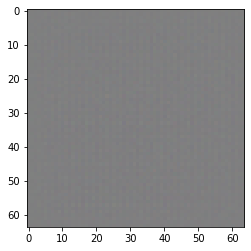

In [68]:
generator = make_generator_model((300,))

noise = np.random.normal(0, 1, 300)
label = train_captions[0]
print(label.shape)

generated_image = generator.predict( [np.array([noise]), np.array([label])] )[0][0]
plt.imshow(unnormalize_img(generated_image), )

In [69]:
def make_valid_discriminator_model():
    input_layer = Input((64, 64, 3))
#     x = GaussianNoise(1)(input_layer)
    
    x = Conv2D(64, (3, 3), strides=(2, 2), padding='same', name='valid')(input_layer)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)
    x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)

    
    x = Conv2D(128, (3, 3), strides=(2, 2), padding='same')(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)
    x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)
    
    
    x = Flatten()(x)
    x = Dense(64)(x) 
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)
    
    valid = Dense(1, activation='sigmoid')(x)
    
    return Model(input_layer, valid)

In [70]:
discriminator_valid = make_valid_discriminator_model()
discriminator_valid.summary()
valid = discriminator_valid.predict(np.array([generated_image]))


Model: "model_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        [(None, 64, 64, 3)]       0         
_________________________________________________________________
valid (Conv2D)               (None, 32, 32, 64)        1792      
_________________________________________________________________
leaky_re_lu_142 (LeakyReLU)  (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_38 (Dropout)         (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 64)        36928     
_________________________________________________________________
leaky_re_lu_143 (LeakyReLU)  (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_39 (Dropout)         (None, 32, 32, 64)        0  

In [71]:
def make_attr_discriminator_model():
    input_layer = Input((64, 64, 3))
    
#     x = GaussianNoise(1)(input_layer)
    
    x = Conv2D(64, (3, 3), strides=(2, 2), padding='same', name='attr')(input_layer)
    x = LeakyReLU()(x)
#     x = Dropout(0.3)(x)
    x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
    x = LeakyReLU()(x)
#     x = Dropout(0.3)(x)

    
    x = Conv2D(128, (3, 3), strides=(2, 2), padding='same')(x)
    x = LeakyReLU()(x)
#     x = Dropout(0.3)(x)
    x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
    x = LeakyReLU()(x)
#     x = Dropout(0.3)(x)


#     x = Conv2D(128, (3, 3), strides=(2, 2), padding='same')(x)
#     x = LeakyReLU()(x)
#     x = Dropout(0.3)(x)
#     x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
#     x = LeakyReLU()(x)
#     x = Dropout(0.3)(x)
    
#     x = Conv2D(256, (3, 3), strides=(2, 2), padding='same')(x)
#     x = LeakyReLU()(x)
#     x = Dropout(0.3)(x)
#     x = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
#     x = LeakyReLU()(x)
#     x = Dropout(0.3)(x)
    
    x = Flatten()(x)
    x = Dense(64)(x)
#     x = Dense(128)(x)
    x = LeakyReLU()(x)
#     x = Dropout(0.3)(x)
    
    x = Dense(48)(x)
#     x = Dense(64)(x)
    x = LeakyReLU()(x)
#     x = Dropout(0.3)(x)
    
    attr = Dense(34, activation='sigmoid')(x)
    
    return Model(input_layer, attr)

In [72]:
discriminator_attr = make_attr_discriminator_model()
discriminator_attr.summary()
attrs = discriminator_attr.predict(np.array([generated_image]))

Model: "model_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        [(None, 64, 64, 3)]       0         
_________________________________________________________________
attr (Conv2D)                (None, 32, 32, 64)        1792      
_________________________________________________________________
leaky_re_lu_147 (LeakyReLU)  (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
leaky_re_lu_148 (LeakyReLU)  (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
leaky_re_lu_149 (LeakyReLU)  (None, 16, 16, 128)       0  

In [25]:
cross_entropy = BinaryCrossentropy(from_logits=False)

@tf.function
def discriminator_valid_loss(real_output, fake_output, flip):
    
    if flip:
        fake_labels = tf.random.uniform(fake_output.shape, minval=0.9, maxval=1.0)
        real_labels = tf.random.uniform(real_output.shape, minval=0.0, maxval=0.1)
    else:
        real_labels = tf.random.uniform(real_output.shape, minval=0.9, maxval=1.0)
        fake_labels = tf.random.uniform(fake_output.shape, minval=0.0, maxval=0.1)

        
    real_loss = cross_entropy(real_labels, real_output)
    fake_loss = cross_entropy(fake_labels, fake_output)
    total_loss = real_loss + fake_loss
    return total_loss, real_loss, fake_loss

In [26]:
# mse = MeanSquaredError()

# loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
#     logits=logits, labels=Y))



@tf.function
def discriminator_attribute_loss_real(real_output, real_attributes, weights):
#     return tf.nn.weighted_cross_entropy_with_logits(real_attributes, real_output, weights)
    return weights * cross_entropy(real_output, real_attributes)

@tf.function
def discriminator_attribute_loss_fake(fake_output, fake_attributes, weights):
#     return tf.nn.weighted_cross_entropy_with_logits(fake_attributes, fake_output, weights)
    return weights * cross_entropy(fake_output, fake_attributes)

In [27]:
@tf.function
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

@tf.function
def generator_attr_loss(fake_attr_output, sampled_attrs, weights):
#     return tf.nn.weighted_cross_entropy_with_logits(sampled_attrs, fake_attr_output, weights)
    return weights * cross_entropy(fake_attr_output, sampled_attrs)


@tf.function
def generator_caption_loss(fake_caption_output, sampled_captions, weights):
#     return tf.nn.weighted_cross_entropy_with_logits(sampled_captions, fake_caption_output, weights)
    return weights * cross_entropy(fake_caption_output, sampled_captions)

In [28]:
@tf.function
def train_step(images, attrs, captions, sampled_attrs, sampled_captions, flip, warmup, weights):
    noise = tf.random.truncated_normal([32, 300], dtype=tf.dtypes.float64)
    
#     sampled_attrs = tf.cast(tf.random.uniform([32, 312], minval=0, maxval=2, dtype='int32'), 'float32') # Need to make this smarter. Only one 1 per attr.
#     attrs = tf.reshape(attrs, (attrs.shape[0], 1))
    
    gen_losses = []
    gen_valid_losses = []
    gen_attr_losses = []
    gen_caption_losses = []
    disc_losses = []
    disc_real_losses = []
    disc_fake_losses = []
    disc_attr_real_losses = []
    disc_attr_fake_losses = []

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape_valid, tf.GradientTape() as disc_tape_attr:
        gen_tape.watch(generator.trainable_variables)
        disc_tape_valid.watch(discriminator_valid.trainable_variables)
        disc_tape_attr.watch(discriminator_attr.trainable_variables)
        
        generated_images, generated_attrs = generator([noise, sampled_captions], training=True)
        
        real_output = discriminator_valid(images, training=True)
        fake_output = discriminator_valid(generated_images, training=True)
        
        real_attr_output = discriminator_attr(images, training=True)
        fake_attr_output = discriminator_attr(generated_images, training=True)
        
        gen_valid_loss = generator_loss(fake_output)
        gen_attr_loss = generator_attr_loss(fake_attr_output, sampled_attrs, weights)
        gen_caption_loss = generator_caption_loss(generated_attrs, sampled_attrs, weights)
        gen_loss = ((2.0 - warmup) * gen_valid_loss + (warmup * (gen_attr_loss)))
#         gen_loss = ((2.0 - warmup) * gen_valid_loss + (warmup * (gen_attr_loss + gen_caption_loss)))
        
        disc_valid_loss, disc_real_loss, disc_fake_loss = discriminator_valid_loss(real_output, fake_output, flip)
        disc_attr_real_loss = discriminator_attribute_loss_real(real_attr_output, attrs, weights)
        disc_attr_fake_loss = discriminator_attribute_loss_fake(fake_attr_output, sampled_attrs, weights)
        disc_attr_loss = ((2.0 - warmup) * disc_attr_real_loss + warmup * disc_attr_fake_loss)
#         disc_loss += ((2.0 - warmup) * disc_attr_real_loss + warmup * disc_attr_fake_loss)
        
        
        gen_losses.append(K.mean(gen_loss))
        gen_valid_losses.append(K.mean(gen_valid_loss))
        gen_attr_losses.append(K.mean(gen_attr_loss))
        gen_caption_losses.append(K.mean(gen_caption_loss))
        disc_losses.append(K.mean(disc_valid_loss))
        disc_real_losses.append(K.mean(disc_real_loss))
        disc_fake_losses.append(K.mean(disc_fake_loss))
        disc_attr_real_losses.append(K.mean(disc_attr_real_loss))
        disc_attr_fake_losses.append(K.mean(disc_attr_fake_loss))
    
    
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)

    gradients_of_discriminator_valid = disc_tape_valid.gradient(disc_valid_loss, discriminator_valid.trainable_variables)
    
    gradients_of_discriminator_attr = disc_tape_attr.gradient(disc_attr_loss, discriminator_attr.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    
    discriminator_valid_optimizer.apply_gradients(zip(gradients_of_discriminator_valid, discriminator_valid.trainable_variables))
    
    discriminator_attr_optimizer.apply_gradients(zip(gradients_of_discriminator_attr, discriminator_attr.trainable_variables))

    return (gen_losses, gen_valid_losses, gen_attr_losses, gen_caption_losses, disc_losses, disc_real_losses, disc_fake_losses, disc_attr_real_losses, disc_attr_fake_losses)

In [213]:
def train(train_imgs, train_attrs, train_captions, epochs, warmup, weights):
    gen_loss_all = []
    gen_valid_loss_all = []
    gen_attr_loss_all = []
    gen_caption_loss_all = []
    disc_loss_all = []
    disc_loss_real_all = []
    disc_loss_fake_all = []
    disc_attr_loss_real_all = []
    disc_attr_loss_fake_all = []
    warmup_step = 1./2000.
    
    num_samples = len(train_imgs)
    batch_counter = 0
    
    for epoch in range(epochs):
        start = time.time()
        
        gen_loss_epoch = [1, 0]
        gen_valid_loss_epoch = [1, 0]
        gen_attr_loss_epoch = [1, 0]
        gen_caption_loss_epoch = [1, 0]
        disc_loss_epoch = [1, 0]
        disc_loss_real_epoch = [1, 0]
        disc_loss_fake_epoch = [1, 0]
        disc_attr_loss_real_epoch = [1, 0]
        disc_attr_loss_fake_epoch = [1, 0]
        
        seed = np.random.randint(0, 10000)
        np.random.seed(seed)
        np.random.shuffle(train_imgs)
        np.random.seed(seed)
        np.random.shuffle(train_attrs)
        np.random.seed(seed)
        np.random.shuffle(train_captions)
        
        all_indices = np.arange(len(train_attrs))
        np.random.shuffle(all_indices)
        
        for idx, i in enumerate(range(0, num_samples - 32, 32)):
            
            sampled_indices = all_indices[i:(i+32)]
            
            gen_loss_batch, gen_valid_loss_batch, gen_attr_loss_batch, gen_caption_loss_batch, disc_loss_batch, disc_loss_real_batch, disc_loss_fake_batch, disc_attr_loss_real_batch, disc_attr_loss_fake_batch = train_step(train_imgs[i:(i+32)], train_attrs[i:(i+32)], train_captions[i:(i+32)], train_attrs[sampled_indices], train_captions[sampled_indices], batch_counter % 20 == 0, tf.constant(warmup, dtype='float32'), tf.constant(weights, dtype='float32'))

            gen_loss_epoch[0] += 1
            gen_valid_loss_epoch[0] += 1
            gen_attr_loss_epoch[0] += 1
            gen_caption_loss_epoch[0] += 1
            disc_loss_epoch[0] += 1
            disc_loss_real_epoch[0] += 1
            disc_loss_fake_epoch[0] += 1
            disc_attr_loss_real_epoch[0] += 1
            disc_attr_loss_fake_epoch[0] += 1
            gen_loss_epoch[1] += np.mean(gen_loss_batch)
            gen_valid_loss_epoch[1] += np.mean(gen_valid_loss_batch)
            gen_attr_loss_epoch[1] += np.mean(gen_attr_loss_batch)
            gen_caption_loss_epoch[1] += np.mean(gen_caption_loss_batch)
            disc_loss_epoch[1] += np.mean(disc_loss_batch)
            disc_loss_real_epoch[1] += np.mean(disc_loss_real_batch)
            disc_loss_fake_epoch[1] += np.mean(disc_loss_fake_batch)
            disc_attr_loss_real_epoch[1] += np.mean(disc_attr_loss_real_batch)
            disc_attr_loss_fake_epoch[1] += np.mean(disc_attr_loss_fake_batch)
            
            batch_counter += 1
            
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
        print(f'Gen loss: {gen_loss_epoch[1]/gen_loss_epoch[0]}, Gen valid loss: {gen_valid_loss_epoch[1]/gen_valid_loss_epoch[0]}, Gen attr loss: {gen_attr_loss_epoch[1]/gen_attr_loss_epoch[0]}, Gen caption loss: {gen_caption_loss_epoch[1]/gen_caption_loss_epoch[0]}, Disc valid loss: {disc_loss_epoch[1]/disc_loss_epoch[0]}, Disc valid real loss: {disc_loss_real_epoch[1]/disc_loss_real_epoch[0]}, Disc valid fake loss: {disc_loss_fake_epoch[1]/disc_loss_fake_epoch[0]}, Disc attr loss: {(disc_attr_loss_real_epoch[1] + disc_attr_loss_fake_epoch[1])/(disc_attr_loss_real_epoch[0])}, Disc attr real loss: {disc_attr_loss_real_epoch[1]/disc_attr_loss_real_epoch[0]}, Disc attr fake loss: {disc_attr_loss_fake_epoch[1]/disc_attr_loss_fake_epoch[0]}')
        
        gen_loss_all.append(gen_loss_epoch[1]/gen_loss_epoch[0])
        gen_valid_loss_all.append(gen_valid_loss_epoch[1]/gen_valid_loss_epoch[0])
        gen_attr_loss_all.append(gen_attr_loss_epoch[1]/gen_attr_loss_epoch[0])
        gen_caption_loss_all.append(gen_caption_loss_epoch[1]/gen_caption_loss_epoch[0])
        disc_loss_all.append(disc_loss_epoch[1]/disc_loss_epoch[0])
        disc_loss_real_all.append(disc_loss_real_epoch[1]/disc_loss_real_epoch[0])
        disc_loss_fake_all.append(disc_loss_fake_epoch[1]/disc_loss_fake_epoch[0])
        disc_attr_loss_real_all.append(disc_attr_loss_real_epoch[1]/disc_attr_loss_real_epoch[0])
        disc_attr_loss_fake_all.append(disc_attr_loss_fake_epoch[1]/disc_attr_loss_fake_epoch[0])
        
        if warmup < 1:
            warmup += warmup_step
    
    return (gen_loss_all, gen_valid_loss_all, gen_attr_loss_all, gen_caption_loss_all, disc_loss_all, disc_loss_real_all, disc_loss_fake_all, disc_attr_loss_real_all, disc_attr_loss_fake_all, warmup)
    


In [198]:
def long_train(starting_checkpoint=0, num_checkpoints=0, checkpoint_interval=0, g_hist=None, g_valid_hist=None, g_attr_hist=None, g_caption_hist=None, d_hist=None, d_real_hist=None, d_fake_hist=None, d_attr_real_hist=None, d_attr_fake_hist=None, noise=None, caption=None, save_files=False, warmup=0., weights=None):

    for i in range(starting_checkpoint, starting_checkpoint + num_checkpoints):
        print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
        print('')
        print(f'Starting checkpoint {i}')
        print('')
        print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
        
        gen_temp, gen_valid_temp, gen_attr_temp, gen_caption_temp, disc_temp, disc_real_temp, disc_fake_temp, disc_attr_real_temp, disc_attr_fake_temp, warmup = train(train_imgs, train_attrs, train_captions, checkpoint_interval, warmup, weights)
        
        g_hist += gen_temp
        g_valid_hist += gen_valid_temp
        g_attr_hist += gen_attr_temp
        g_caption_hist += gen_caption_temp
        d_hist += disc_temp
        d_real_hist += disc_real_temp
        d_fake_hist += disc_fake_temp
        d_attr_real_hist += disc_attr_real_temp
        d_attr_fake_hist += disc_attr_fake_temp
        generated_image = generator.predict( [np.array([noise]), np.array([caption])])[0][0]
        plt.imshow(unnormalize_img(generated_image))
        if save_files:
            plt.savefig('./results/prog-imgs/bird-gan-attributes-split-captions-concat-caption-loss-autoencoder-34-weighted/' + str((i+1)*checkpoint_interval) + '.png')
        plt.show()
        if save_files:
            generator.save_weights('./results/weights/bird-gan-attributes-split-captions-concat-caption-loss-autoencoder-34-weighted/gen_weights_attributes_split_' + str((i+1)*checkpoint_interval) + '.h5')
            discriminator_valid.save_weights('./results/weights/bird-gan-attributes-split-captions-concat-caption-loss-autoencoder-34-weighted/disc_weights_attributes_split_valid_' + str((i+1)*checkpoint_interval) + '.h5')
            discriminator_attr.save_weights('./results/weights/bird-gan-attributes-split-captions-concat-caption-loss-autoencoder-34-weighted/disc_weights_attributes_split_attr_' + str((i+1)*checkpoint_interval) + '.h5')
        
        d = dict.fromkeys([i for i in range(34)], 0)
        prediction = discriminator_attr.predict(np.array(train_imgs))
        prediction = np.round(tf.math.sigmoid(prediction))
        for p in prediction:
            p = np.where(p == 1)
            for i in p[0]:
                d[i] += 1
    
        plt.bar([x for x in range(34)], d.values())
        plt.show()
    
    return starting_checkpoint + num_checkpoints, totalepochs, warmup

In [29]:
discriminator_valid = make_valid_discriminator_model()
discriminator_attr = make_attr_discriminator_model()
generator = make_generator_model((300,))
generator_optimizer = Adam(1e-4, beta_1=0.5)
discriminator_valid_optimizer = Adam(1e-4, beta_1=0.5)
discriminator_attr_optimizer = Adam(1e-5, beta_1=0.5)

In [30]:
# To get passed into training function and get modified
# Run cell when starting from scratch
gen_loss_hist = []
gen_valid_loss_hist = []
gen_attr_loss_hist = []
gen_caption_loss_hist = []
disc_loss_hist = []
disc_loss_real_hist = []
disc_loss_fake_hist = []
disc_attr_loss_real_hist = []
disc_attr_loss_fake_hist = []
noise300 = np.random.normal(0, 1, 300)
caption = train_captions[5000]
next_starting_checkpoint = 0
totalepochs = 0
warmup = 1.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 0

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 35.46623420715332 sec
Gen loss: 3.5216768828187854, Gen valid loss: 1.2876937655898613, Gen attr loss: 2.233983125790025, Gen caption loss: 1.1895747790491678, Disc valid loss: 1.06757734865354, Disc valid real loss: 0.5688347355298556, Disc valid fake loss: 0.4987426138505703, Disc attr loss: 4.468003346668026, Disc attr real loss: 2.2340202208780013, Disc attr fake loss: 2.233983125790025
Time for epoch 2 is 36.91307735443115 sec
Gen loss: 3.5111674351420827, Gen valid loss: 1.276917128058953, Gen attr loss: 2.234250323882271, Gen caption loss: 1.1894808784732973, Disc valid loss: 1.0594840468106876, Disc valid real loss: 0.5605989092895332, Disc valid fake loss: 0.4988851366327384, Disc attr loss: 4.468500208402391, Disc attr real loss: 2.23424988452012, Disc attr fake loss: 2.234250323882271
Time for epoch 3 is 38.01629090309143 sec
Gen loss: 3.508

Time for epoch 21 is 38.48667812347412 sec
Gen loss: 3.497374526207363, Gen valid loss: 1.2630850924708978, Gen attr loss: 2.2342894490818344, Gen caption loss: 1.1894430968819596, Disc valid loss: 1.0760502081899461, Disc valid real loss: 0.57102044245738, Disc valid fake loss: 0.5050297629057876, Disc attr loss: 4.468274529064251, Disc attr real loss: 2.2339850799824164, Disc attr fake loss: 2.2342894490818344
Time for epoch 22 is 38.462716579437256 sec
Gen loss: 3.4910802912259813, Gen valid loss: 1.256745853882818, Gen attr loss: 2.234334435243271, Gen caption loss: 1.189513850179791, Disc valid loss: 1.0795808153423836, Disc valid real loss: 0.5702714581638171, Disc valid fake loss: 0.509309357501627, Disc attr loss: 4.468621133142694, Disc attr real loss: 2.234286697899423, Disc attr fake loss: 2.234334435243271
Time for epoch 23 is 38.44671034812927 sec
Gen loss: 3.475390422634962, Gen valid loss: 1.2414850111253217, Gen attr loss: 2.2339054132864726, Gen caption loss: 1.1897178

Time for epoch 41 is 38.465407371520996 sec
Gen loss: 3.4630241814021496, Gen valid loss: 1.2289785649072187, Gen attr loss: 2.2340456098721924, Gen caption loss: 1.1895386135675075, Disc valid loss: 1.0857935051930951, Disc valid real loss: 0.5759448108634329, Disc valid fake loss: 0.509848694814253, Disc attr loss: 4.468413917352836, Disc attr real loss: 2.234368307480644, Disc attr fake loss: 2.2340456098721924
Time for epoch 42 is 38.45350766181946 sec
Gen loss: 3.461260479640185, Gen valid loss: 1.2273135204625323, Gen attr loss: 2.233946942378512, Gen caption loss: 1.1895107570379406, Disc valid loss: 1.0865754183068832, Disc valid real loss: 0.5755037112933833, Disc valid fake loss: 0.511071708790332, Disc attr loss: 4.468228323349785, Disc attr real loss: 2.234281380971273, Disc attr fake loss: 2.233946942378512
Time for epoch 43 is 38.495424032211304 sec
Gen loss: 3.459820594890977, Gen valid loss: 1.2253784858760473, Gen attr loss: 2.2344421031998425, Gen caption loss: 1.1896

Time for epoch 61 is 38.488866329193115 sec
Gen loss: 3.0416455016872748, Gen valid loss: 1.2007424765162997, Gen attr loss: 1.8409030043335788, Gen caption loss: 1.1895622528665435, Disc valid loss: 1.1028103597441985, Disc valid real loss: 0.5820139118326388, Disc valid fake loss: 0.5207964507383382, Disc attr loss: 3.6814894110852787, Disc attr real loss: 1.8405864067517, Disc attr fake loss: 1.8409030043335788
Time for epoch 62 is 38.45318341255188 sec
Gen loss: 3.061710065619409, Gen valid loss: 1.220983305597693, Gen attr loss: 1.8407267642215015, Gen caption loss: 1.1892737279416423, Disc valid loss: 1.0965432132162698, Disc valid real loss: 0.5767804664486469, Disc valid fake loss: 0.5197627460407371, Disc attr loss: 3.6818984708165736, Disc attr real loss: 1.841171706595072, Disc attr fake loss: 1.8407267642215015
Time for epoch 63 is 38.454997539520264 sec
Gen loss: 3.0556484489906124, Gen valid loss: 1.2147839812405388, Gen attr loss: 1.840864447074208, Gen caption loss: 1.1

Time for epoch 81 is 38.47052049636841 sec
Gen loss: 3.073463797892335, Gen valid loss: 1.2325211028419536, Gen attr loss: 1.8409426903660058, Gen caption loss: 1.1893212338127095, Disc valid loss: 1.0953191702928, Disc valid real loss: 0.576650634690675, Disc valid fake loss: 0.5186685347137089, Disc attr loss: 3.682092668564339, Disc attr real loss: 1.8411499781983331, Disc attr fake loss: 1.8409426903660058
Time for epoch 82 is 38.45158100128174 sec
Gen loss: 3.0607123575236415, Gen valid loss: 1.219717133497481, Gen attr loss: 1.8409952186956637, Gen caption loss: 1.1894838444908784, Disc valid loss: 1.0863189282133003, Disc valid real loss: 0.5726522082074225, Disc valid fake loss: 0.5136667187944014, Disc attr loss: 3.681926747324667, Disc attr real loss: 1.8409315286290031, Disc attr fake loss: 1.8409952186956637
Time for epoch 83 is 38.487189292907715 sec
Gen loss: 3.064492810386306, Gen valid loss: 1.2237226667442942, Gen attr loss: 1.8407701402498777, Gen caption loss: 1.1895

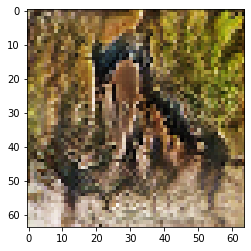

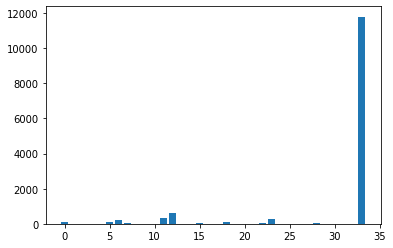

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 1

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 38.41862940788269 sec
Gen loss: 2.9309801538462237, Gen valid loss: 1.222702591238306, Gen attr loss: 1.708277565353931, Gen caption loss: 1.189684126758317, Disc valid loss: 1.093033301959516, Disc valid real loss: 0.5714107308445907, Disc valid fake loss: 0.5216225713572205, Disc attr loss: 3.4161568049815934, Disc attr real loss: 1.7078792396276623, Disc attr fake loss: 1.708277565353931
Time for epoch 2 is 38.48591208457947 sec
Gen loss: 2.929027816467492, Gen valid loss: 1.2204911269469636, Gen attr loss: 1.7085366846746222, Gen caption loss: 1.1897247708263758, Disc valid loss: 1.0908136760316245, Disc valid real loss: 0.5740804691624836, Disc valid fake loss: 0.516733207030671, Disc attr loss: 3.416608919942282, Disc attr real loss: 1.7080722352676598, Disc attr fake loss: 1.7085366846746222
Time for epoch 3 is 38.4638569355011 sec
Gen loss: 2.9

Time for epoch 21 is 38.434324502944946 sec
Gen loss: 2.923284016973604, Gen valid loss: 1.2155369261739053, Gen attr loss: 1.7077470856307322, Gen caption loss: 1.1893853291586485, Disc valid loss: 1.0997484271442342, Disc valid real loss: 0.5755290851037353, Disc valid fake loss: 0.5242193411520826, Disc attr loss: 3.415177030291984, Disc attr real loss: 1.7074299446612515, Disc attr fake loss: 1.7077470856307322
Time for epoch 22 is 38.44065237045288 sec
Gen loss: 2.950135740807386, Gen valid loss: 1.2419401449239673, Gen attr loss: 1.708195587483848, Gen caption loss: 1.1895924756520486, Disc valid loss: 1.0954503638311452, Disc valid real loss: 0.573276925781555, Disc valid fake loss: 0.5221734394225971, Disc attr loss: 3.415642494108619, Disc attr real loss: 1.7074469066247708, Disc attr fake loss: 1.708195587483848
Time for epoch 23 is 38.43872356414795 sec
Gen loss: 2.912864414980095, Gen valid loss: 1.2043227640593923, Gen attr loss: 1.7085416559281388, Gen caption loss: 1.189

Time for epoch 41 is 38.43603515625 sec
Gen loss: 2.936613946103145, Gen valid loss: 1.2282749424943433, Gen attr loss: 1.7083390130583187, Gen caption loss: 1.1895267284982574, Disc valid loss: 1.1069903234802287, Disc valid real loss: 0.5748117795481591, Disc valid fake loss: 0.5321785423975327, Disc attr loss: 3.4146670019077416, Disc attr real loss: 1.7063279888494227, Disc attr fake loss: 1.7083390130583187
Time for epoch 42 is 38.45086479187012 sec
Gen loss: 2.90383346358612, Gen valid loss: 1.1952909198879873, Gen attr loss: 1.7085425391752869, Gen caption loss: 1.1897027046699835, Disc valid loss: 1.104210139128574, Disc valid real loss: 0.5810486543469313, Disc valid fake loss: 0.5231614846201124, Disc attr loss: 3.415161320833656, Disc attr real loss: 1.706618781658369, Disc attr fake loss: 1.7085425391752869
Time for epoch 43 is 38.43133997917175 sec
Gen loss: 2.9295663387794804, Gen valid loss: 1.2210247563475838, Gen attr loss: 1.7085415764552792, Gen caption loss: 1.18936

Time for epoch 61 is 38.46403646469116 sec
Gen loss: 2.9247355163905033, Gen valid loss: 1.2162357982258163, Gen attr loss: 1.7084997020116666, Gen caption loss: 1.1893961235759705, Disc valid loss: 1.1061356801004592, Disc valid real loss: 0.5752617323463202, Disc valid fake loss: 0.5308739472695483, Disc attr loss: 3.414423228279362, Disc attr real loss: 1.7059235262676953, Disc attr fake loss: 1.7084997020116666
Time for epoch 62 is 38.43138933181763 sec
Gen loss: 2.9187144076598046, Gen valid loss: 1.210573135191186, Gen attr loss: 1.7081412729532093, Gen caption loss: 1.1896851350298419, Disc valid loss: 1.1007287836656339, Disc valid real loss: 0.5742537917968057, Disc valid fake loss: 0.5264749928380092, Disc attr loss: 3.4139434893925986, Disc attr real loss: 1.7058022164393893, Disc attr fake loss: 1.7081412729532093
Time for epoch 63 is 38.43685960769653 sec
Gen loss: 2.9323144786080046, Gen valid loss: 1.2238656967312986, Gen attr loss: 1.7084487851073102, Gen caption loss: 

Time for epoch 81 is 38.45926380157471 sec
Gen loss: 2.921081262552318, Gen valid loss: 1.2127593589345937, Gen attr loss: 1.7083219031331338, Gen caption loss: 1.1894184674027812, Disc valid loss: 1.102229475328916, Disc valid real loss: 0.5775779068146941, Disc valid fake loss: 0.5246515676258056, Disc attr loss: 3.4135067123707716, Disc attr real loss: 1.7051848092376378, Disc attr fake loss: 1.7083219031331338
Time for epoch 82 is 38.48618197441101 sec
Gen loss: 2.9258304889286113, Gen valid loss: 1.2170519361974101, Gen attr loss: 1.7087785538619127, Gen caption loss: 1.189723487468916, Disc valid loss: 1.097031058496253, Disc valid real loss: 0.5727568362463458, Disc valid fake loss: 0.5242742234613837, Disc attr loss: 3.4139417884795646, Disc attr real loss: 1.705163234617652, Disc attr fake loss: 1.7087785538619127
Time for epoch 83 is 38.45533633232117 sec
Gen loss: 2.943276725810395, Gen valid loss: 1.234484768495327, Gen attr loss: 1.7087919540844636, Gen caption loss: 1.189

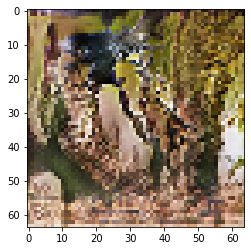

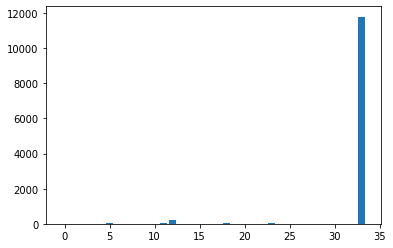

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 2

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 38.2009072303772 sec
Gen loss: 2.925922090768168, Gen valid loss: 1.2159770620547659, Gen attr loss: 1.7099450296825833, Gen caption loss: 1.1894474265375112, Disc valid loss: 1.103406392300355, Disc valid real loss: 0.5738575068431172, Disc valid fake loss: 0.5295488851341775, Disc attr loss: 3.413678606028156, Disc attr real loss: 1.703733576345573, Disc attr fake loss: 1.7099450296825833
Time for epoch 2 is 38.45005774497986 sec
Gen loss: 2.913553655309083, Gen valid loss: 1.204827715872426, Gen attr loss: 1.7087259505822407, Gen caption loss: 1.1894994156793528, Disc valid loss: 1.0980866452865807, Disc valid real loss: 0.5728244980983941, Disc valid fake loss: 0.5252621476727772, Disc attr loss: 3.4120135543146106, Disc attr real loss: 1.70328760373237, Disc attr fake loss: 1.7087259505822407
Time for epoch 3 is 38.435155391693115 sec
Gen loss: 2.

Time for epoch 21 is 38.42837977409363 sec
Gen loss: 2.9075223598376847, Gen valid loss: 1.1984933143062644, Gen attr loss: 1.7090290574846552, Gen caption loss: 1.18943921531119, Disc valid loss: 1.1069484619590324, Disc valid real loss: 0.5817585968712804, Disc valid fake loss: 0.5251898637955105, Disc attr loss: 3.412609741616701, Disc attr real loss: 1.7035806841320462, Disc attr fake loss: 1.7090290574846552
Time for epoch 22 is 38.41031289100647 sec
Gen loss: 2.904757995915607, Gen valid loss: 1.1960613070141655, Gen attr loss: 1.708696691970515, Gen caption loss: 1.1895663101821734, Disc valid loss: 1.108465418421479, Disc valid real loss: 0.5784240423986905, Disc valid fake loss: 0.5300413764266141, Disc attr loss: 3.4133132331093474, Disc attr real loss: 1.7046165411388325, Disc attr fake loss: 1.708696691970515
Time for epoch 23 is 38.468854665756226 sec
Gen loss: 2.907874373562614, Gen valid loss: 1.1991288314666853, Gen attr loss: 1.7087455564721168, Gen caption loss: 1.189

Time for epoch 41 is 38.11289620399475 sec
Gen loss: 2.9126658730390593, Gen valid loss: 1.2044653844058029, Gen attr loss: 1.7082005031709748, Gen caption loss: 1.1897152074307284, Disc valid loss: 1.1047123282905515, Disc valid real loss: 0.5771479250454321, Disc valid fake loss: 0.5275644061526632, Disc attr loss: 3.410680866176843, Disc attr real loss: 1.7024803630058682, Disc attr fake loss: 1.7082005031709748
Time for epoch 42 is 38.40195894241333 sec
Gen loss: 2.9100816482450904, Gen valid loss: 1.2015918364046712, Gen attr loss: 1.7084898170093856, Gen caption loss: 1.189594703961194, Disc valid loss: 1.1005438436983723, Disc valid real loss: 0.5735941281325125, Disc valid fake loss: 0.52694971572739, Disc attr loss: 3.411162018129819, Disc attr real loss: 1.7026722011204334, Disc attr fake loss: 1.7084898170093856
Time for epoch 43 is 38.205665826797485 sec
Gen loss: 2.901808119078639, Gen valid loss: 1.1930112950200957, Gen attr loss: 1.7087968293890397, Gen caption loss: 1.1

Time for epoch 61 is 38.25080394744873 sec
Gen loss: 2.7858227946893956, Gen valid loss: 1.2089138420293648, Gen attr loss: 1.5769089573444066, Gen caption loss: 1.1897207618082766, Disc valid loss: 1.1093713280954336, Disc valid real loss: 0.576619479472075, Disc valid fake loss: 0.5327518489464189, Disc attr loss: 3.2406704002602638, Disc attr real loss: 1.663761442915857, Disc attr fake loss: 1.5769089573444066
Time for epoch 62 is 38.221611738204956 sec
Gen loss: 2.786222861711249, Gen valid loss: 1.2206733047477598, Gen attr loss: 1.5655495471101466, Gen caption loss: 1.1893833935422302, Disc valid loss: 1.0891461792354016, Disc valid real loss: 0.5697758021716502, Disc valid fake loss: 0.5193703749638586, Disc attr loss: 3.232455612198124, Disc attr real loss: 1.6669060650879775, Disc attr fake loss: 1.5655495471101466
Time for epoch 63 is 38.210206270217896 sec
Gen loss: 2.780983190226361, Gen valid loss: 1.2158930025449612, Gen attr loss: 1.5650901794433594, Gen caption loss: 1

Time for epoch 81 is 37.985721826553345 sec
Gen loss: 2.748741797315396, Gen valid loss: 1.2178887606959357, Gen attr loss: 1.530853030804373, Gen caption loss: 1.1895426959203188, Disc valid loss: 1.1053754884376112, Disc valid real loss: 0.5793217494881896, Disc valid fake loss: 0.5260537403224284, Disc attr loss: 3.192328749633417, Disc attr real loss: 1.6614757188290439, Disc attr fake loss: 1.530853030804373
Time for epoch 82 is 37.93342137336731 sec
Gen loss: 2.7441348241273626, Gen valid loss: 1.2134976834462587, Gen attr loss: 1.53063713761203, Gen caption loss: 1.1897121306034284, Disc valid loss: 1.0966819826826493, Disc valid real loss: 0.5758912324259274, Disc valid fake loss: 0.5207907529219702, Disc attr loss: 3.191741157676469, Disc attr real loss: 1.6611040200644391, Disc attr fake loss: 1.53063713761203
Time for epoch 83 is 38.37624406814575 sec
Gen loss: 2.738330371980745, Gen valid loss: 1.2091715867280315, Gen attr loss: 1.529158777983854, Gen caption loss: 1.189594

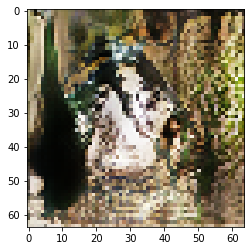

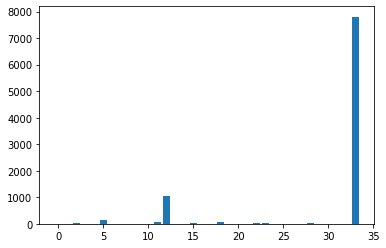

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 3

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 37.96694588661194 sec
Gen loss: 2.7516898650140944, Gen valid loss: 1.2543686347279122, Gen attr loss: 1.4973212260863968, Gen caption loss: 1.189619255905875, Disc valid loss: 1.0958300216734247, Disc valid real loss: 0.5665595424046038, Disc valid fake loss: 0.5292704790265257, Disc attr loss: 3.1554147922572726, Disc attr real loss: 1.658093566170876, Disc attr fake loss: 1.4973212260863968
Time for epoch 2 is 38.082451581954956 sec
Gen loss: 2.7238084113371728, Gen valid loss: 1.2256765044155482, Gen attr loss: 1.4981319086984568, Gen caption loss: 1.1895335463650505, Disc valid loss: 1.086410129942545, Disc valid real loss: 0.5716490420868726, Disc valid fake loss: 0.5147610835751221, Disc attr loss: 3.155816271053097, Disc attr real loss: 1.6576843623546405, Disc attr fake loss: 1.4981319086984568
Time for epoch 3 is 38.015740156173706 sec
Gen lo

Time for epoch 21 is 37.97285270690918 sec
Gen loss: 2.7299324173914385, Gen valid loss: 1.2570542169780266, Gen attr loss: 1.4728781992827005, Gen caption loss: 1.1898026681204799, Disc valid loss: 1.091163097035271, Disc valid real loss: 0.568556381434929, Disc valid fake loss: 0.5226067157618721, Disc attr loss: 3.126389525770172, Disc attr real loss: 1.6535113264874715, Disc attr fake loss: 1.4728781992827005
Time for epoch 22 is 38.17994141578674 sec
Gen loss: 2.687594188907282, Gen valid loss: 1.2193596972036491, Gen attr loss: 1.4682344834655927, Gen caption loss: 1.1897510506596345, Disc valid loss: 1.0942881850369255, Disc valid real loss: 0.5735341010862572, Disc valid fake loss: 0.5207540845160239, Disc attr loss: 3.12322462380417, Disc attr real loss: 1.6549901403385772, Disc attr fake loss: 1.4682344834655927
Time for epoch 23 is 38.10704207420349 sec
Gen loss: 2.689337596660707, Gen valid loss: 1.222859480193637, Gen attr loss: 1.4664780961142645, Gen caption loss: 1.1896

Time for epoch 41 is 38.227006912231445 sec
Gen loss: 2.685666516544373, Gen valid loss: 1.2281314599804762, Gen attr loss: 1.4575350588253198, Gen caption loss: 1.1893487898960993, Disc valid loss: 1.0879524699071559, Disc valid real loss: 0.5677206387041707, Disc valid fake loss: 0.5202318304760992, Disc attr loss: 3.108136887149759, Disc attr real loss: 1.6506018283244395, Disc attr fake loss: 1.4575350588253198
Time for epoch 42 is 38.194091796875 sec
Gen loss: 2.6935809679470735, Gen valid loss: 1.2351424947663698, Gen attr loss: 1.4584384675271467, Gen caption loss: 1.1894681111260805, Disc valid loss: 1.0905597906125593, Disc valid real loss: 0.5725805878154631, Disc valid fake loss: 0.5179792036855124, Disc attr loss: 3.1087157025246763, Disc attr real loss: 1.6502772349975297, Disc attr fake loss: 1.4584384675271467
Time for epoch 43 is 38.249836921691895 sec
Gen loss: 2.695912854781319, Gen valid loss: 1.2361707212479134, Gen attr loss: 1.4597421325642241, Gen caption loss: 1

Time for epoch 61 is 38.208059310913086 sec
Gen loss: 2.6767283513294005, Gen valid loss: 1.2234898963917884, Gen attr loss: 1.4532384613988198, Gen caption loss: 1.1897016479393978, Disc valid loss: 1.1023317913052835, Disc valid real loss: 0.577077003190834, Disc valid fake loss: 0.5252547875490938, Disc attr loss: 3.097232281031001, Disc attr real loss: 1.6439938196321813, Disc attr fake loss: 1.4532384613988198
Time for epoch 62 is 38.26983571052551 sec
Gen loss: 2.683513180673284, Gen valid loss: 1.2305266673002786, Gen attr loss: 1.4529865182189114, Gen caption loss: 1.189466522153477, Disc valid loss: 1.093637883986238, Disc valid real loss: 0.5732194635118573, Disc valid fake loss: 0.5204184194244343, Disc attr loss: 3.0984792127841856, Disc attr real loss: 1.6454926945652741, Disc attr fake loss: 1.4529865182189114
Time for epoch 63 is 38.202839612960815 sec
Gen loss: 2.687315488572366, Gen valid loss: 1.2316510189516434, Gen attr loss: 1.4556644608980918, Gen caption loss: 1.

Time for epoch 81 is 38.20615744590759 sec
Gen loss: 2.6901216862324455, Gen valid loss: 1.235564087949148, Gen attr loss: 1.4545576016754316, Gen caption loss: 1.189724884059048, Disc valid loss: 1.0886115590085181, Disc valid real loss: 0.5674242287631927, Disc valid fake loss: 0.5211873335566947, Disc attr loss: 3.0957645319987765, Disc attr real loss: 1.641206930323345, Disc attr fake loss: 1.4545576016754316
Time for epoch 82 is 38.249178886413574 sec
Gen loss: 2.677174945510823, Gen valid loss: 1.2269022280607766, Gen attr loss: 1.4502727190653484, Gen caption loss: 1.1895011757124407, Disc valid loss: 1.0910842969488646, Disc valid real loss: 0.5684040003837285, Disc valid fake loss: 0.5226802951921292, Disc attr loss: 3.0931289435079106, Disc attr real loss: 1.6428562244425622, Disc attr fake loss: 1.4502727190653484
Time for epoch 83 is 38.23225712776184 sec
Gen loss: 2.6878378914623724, Gen valid loss: 1.2344353916199227, Gen attr loss: 1.453402495965725, Gen caption loss: 1.

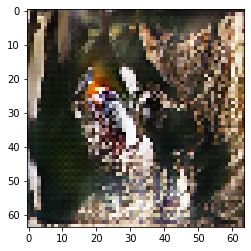

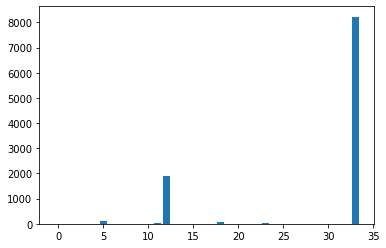

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 4

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 38.27451467514038 sec
Gen loss: 2.6892014325149662, Gen valid loss: 1.2365840125859269, Gen attr loss: 1.4526174175060862, Gen caption loss: 1.189675057160499, Disc valid loss: 1.0903277206550122, Disc valid real loss: 0.5655549495685391, Disc valid fake loss: 0.5247727709249429, Disc attr loss: 3.0900415825003855, Disc attr real loss: 1.6374241649942993, Disc attr fake loss: 1.4526174175060862
Time for epoch 2 is 38.24892258644104 sec
Gen loss: 2.680427719260942, Gen valid loss: 1.2252087843450428, Gen attr loss: 1.4552189444461812, Gen caption loss: 1.1896478389982932, Disc valid loss: 1.0903544610108786, Disc valid real loss: 0.5674006250815663, Disc valid fake loss: 0.5229538370600237, Disc attr loss: 3.0943649154368456, Disc attr real loss: 1.6391459709906642, Disc attr fake loss: 1.4552189444461812
Time for epoch 3 is 38.1891667842865 sec
Gen los

Time for epoch 21 is 38.25895023345947 sec
Gen loss: 2.6670193523572387, Gen valid loss: 1.2137662225622472, Gen attr loss: 1.4532531273720388, Gen caption loss: 1.1895125207862234, Disc valid loss: 1.096284010384464, Disc valid real loss: 0.5711840517152615, Disc valid fake loss: 0.5250999602845045, Disc attr loss: 3.086844254961505, Disc attr real loss: 1.6335911275894661, Disc attr fake loss: 1.4532531273720388
Time for epoch 22 is 38.372679710388184 sec
Gen loss: 2.6679202586331665, Gen valid loss: 1.217210230627034, Gen attr loss: 1.4507100359211123, Gen caption loss: 1.189527751630561, Disc valid loss: 1.0995340730116618, Disc valid real loss: 0.5787305788296025, Disc valid fake loss: 0.520803497816489, Disc attr loss: 3.083179263564629, Disc attr real loss: 1.6324692276435169, Disc attr fake loss: 1.4507100359211123
Time for epoch 23 is 38.23918414115906 sec
Gen loss: 2.6782391568832606, Gen valid loss: 1.2268225528037322, Gen attr loss: 1.451416599072092, Gen caption loss: 1.18

Time for epoch 41 is 38.21673536300659 sec
Gen loss: 2.6883646085010313, Gen valid loss: 1.2353748776079194, Gen attr loss: 1.452989722978132, Gen caption loss: 1.1895727539450172, Disc valid loss: 1.089254390418045, Disc valid real loss: 0.5651486418273067, Disc valid fake loss: 0.5241057483484428, Disc attr loss: 3.0849206008239167, Disc attr real loss: 1.6319308778457848, Disc attr fake loss: 1.452989722978132
Time for epoch 42 is 38.20731234550476 sec
Gen loss: 2.689619410651809, Gen valid loss: 1.2376373763976058, Gen attr loss: 1.4519820277929951, Gen caption loss: 1.189646147454011, Disc valid loss: 1.091529500839833, Disc valid real loss: 0.568135766479058, Disc valid fake loss: 0.5233937339569495, Disc attr loss: 3.082932257716895, Disc attr real loss: 1.6309502299238996, Disc attr fake loss: 1.4519820277929951
Time for epoch 43 is 38.2456214427948 sec
Gen loss: 2.6783296519178683, Gen valid loss: 1.2261098429439514, Gen attr loss: 1.4522198138198232, Gen caption loss: 1.18961

Time for epoch 61 is 38.04086971282959 sec
Gen loss: 2.6877278099215127, Gen valid loss: 1.2358505281652539, Gen attr loss: 1.451877273841279, Gen caption loss: 1.1894297977773154, Disc valid loss: 1.0919014522376744, Disc valid real loss: 0.5683754804496196, Disc valid fake loss: 0.5235259712226992, Disc attr loss: 3.076074654816935, Disc attr real loss: 1.624197380975656, Disc attr fake loss: 1.451877273841279
Time for epoch 62 is 38.074219942092896 sec
Gen loss: 2.677005534572653, Gen valid loss: 1.2248753567698203, Gen attr loss: 1.452130174895289, Gen caption loss: 1.1895217013552906, Disc valid loss: 1.0922875354283548, Disc valid real loss: 0.5656873730786125, Disc valid fake loss: 0.5266001633996886, Disc attr loss: 3.076876450683366, Disc attr real loss: 1.624746275788077, Disc attr fake loss: 1.452130174895289
Time for epoch 63 is 38.03447222709656 sec
Gen loss: 2.676596564652151, Gen valid loss: 1.2258577925079883, Gen attr loss: 1.4507387663290752, Gen caption loss: 1.18943

Time for epoch 81 is 38.32007694244385 sec
Gen loss: 2.6828961133310787, Gen valid loss: 1.2276967899586126, Gen attr loss: 1.4551993114192312, Gen caption loss: 1.189646451130792, Disc valid loss: 1.1036743040330366, Disc valid real loss: 0.574560635377398, Disc valid fake loss: 0.5291136694632894, Disc attr loss: 3.0765112732161026, Disc attr real loss: 1.6213119617968716, Disc attr fake loss: 1.4551993114192312
Time for epoch 82 is 37.95728611946106 sec
Gen loss: 2.6916795345502815, Gen valid loss: 1.2358290339873088, Gen attr loss: 1.455850503955107, Gen caption loss: 1.1893470387471723, Disc valid loss: 1.0896206102397061, Disc valid real loss: 0.5676379345942965, Disc valid fake loss: 0.5219826772607116, Disc attr loss: 3.0773394970389885, Disc attr real loss: 1.6214889930838814, Disc attr fake loss: 1.455850503955107
Time for epoch 83 is 38.37175440788269 sec
Gen loss: 2.6923989706892306, Gen valid loss: 1.2376721916483024, Gen attr loss: 1.4547267703182976, Gen caption loss: 1.

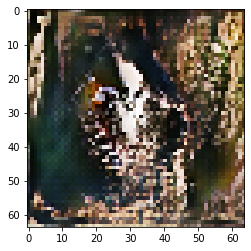

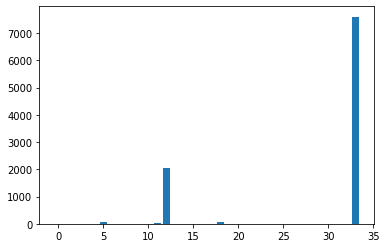

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 5

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 38.19272971153259 sec
Gen loss: 2.6708080607055003, Gen valid loss: 1.2198849935841753, Gen attr loss: 1.4509230583986938, Gen caption loss: 1.1895816400445252, Disc valid loss: 1.1000990106807491, Disc valid real loss: 0.5790162566231518, Disc valid fake loss: 0.5210827560767248, Disc attr loss: 3.069579740849937, Disc attr real loss: 1.618656682451243, Disc attr fake loss: 1.4509230583986938
Time for epoch 2 is 38.170645236968994 sec
Gen loss: 2.6955163724377225, Gen valid loss: 1.2458782785630163, Gen attr loss: 1.4496380979129615, Gen caption loss: 1.1896894588703062, Disc valid loss: 1.084117871151384, Disc valid real loss: 0.5625836201476534, Disc valid fake loss: 0.5215342503576098, Disc attr loss: 3.067496471611788, Disc attr real loss: 1.6178583736988263, Disc attr fake loss: 1.4496380979129615
Time for epoch 3 is 38.24222445487976 sec
Gen los

Time for epoch 21 is 38.3519070148468 sec
Gen loss: 2.6740675799568816, Gen valid loss: 1.223332424150896, Gen attr loss: 1.4507351457911133, Gen caption loss: 1.189521924913091, Disc valid loss: 1.1016873883684153, Disc valid real loss: 0.5731033111813915, Disc valid fake loss: 0.5285840744410104, Disc attr loss: 3.0668666708437087, Disc attr real loss: 1.6161315250525952, Disc attr fake loss: 1.4507351457911133
Time for epoch 22 is 38.38554382324219 sec
Gen loss: 2.6785554627415933, Gen valid loss: 1.2297895129134016, Gen attr loss: 1.4487659579047019, Gen caption loss: 1.1894349620594242, Disc valid loss: 1.0876990025282551, Disc valid real loss: 0.5678420091063027, Disc valid fake loss: 0.5198569914835901, Disc attr loss: 3.0649809078149355, Disc attr real loss: 1.6162149499102336, Disc attr fake loss: 1.4487659579047019
Time for epoch 23 is 38.36548686027527 sec
Gen loss: 2.6884635754717077, Gen valid loss: 1.238321022774146, Gen attr loss: 1.4501425444595213, Gen caption loss: 1.

Time for epoch 41 is 38.220272064208984 sec
Gen loss: 2.6760172818088273, Gen valid loss: 1.2264541705772483, Gen attr loss: 1.4495631269000087, Gen caption loss: 1.1894913272159855, Disc valid loss: 1.09865349773469, Disc valid real loss: 0.5738834594969504, Disc valid fake loss: 0.5247700388838605, Disc attr loss: 3.0643388572424084, Disc attr real loss: 1.6147757303423997, Disc attr fake loss: 1.4495631269000087
Time for epoch 42 is 38.21129536628723 sec
Gen loss: 2.685654863755554, Gen valid loss: 1.2351551265897467, Gen attr loss: 1.450499742980895, Gen caption loss: 1.1894431763548192, Disc valid loss: 1.0905827931595367, Disc valid real loss: 0.5689426592695035, Disc valid fake loss: 0.521640136232221, Disc attr loss: 3.0627912848299435, Disc attr real loss: 1.6122915418490484, Disc attr fake loss: 1.450499742980895
Time for epoch 43 is 38.21325349807739 sec
Gen loss: 2.667291161167589, Gen valid loss: 1.2185284889487393, Gen attr loss: 1.4487626739956823, Gen caption loss: 1.18

Time for epoch 61 is 38.22168278694153 sec
Gen loss: 2.68203065388894, Gen valid loss: 1.2325203536648737, Gen attr loss: 1.4495103026470195, Gen caption loss: 1.1895405076706635, Disc valid loss: 1.1032154490631125, Disc valid real loss: 0.5752717429383337, Disc valid fake loss: 0.5279437044287115, Disc attr loss: 3.0605939839913594, Disc attr real loss: 1.6110836813443399, Disc attr fake loss: 1.4495103026470195
Time for epoch 62 is 38.257139921188354 sec
Gen loss: 2.7007266906541862, Gen valid loss: 1.2466531575210695, Gen attr loss: 1.45407354379411, Gen caption loss: 1.1896146878317442, Disc valid loss: 1.0884025213195057, Disc valid real loss: 0.562029134936449, Disc valid fake loss: 0.5263733879983586, Disc attr loss: 3.0659781300278537, Disc attr real loss: 1.6119045862337438, Disc attr fake loss: 1.45407354379411
Time for epoch 63 is 38.237603187561035 sec
Gen loss: 2.6888162831303872, Gen valid loss: 1.236872681111178, Gen attr loss: 1.4519435884506722, Gen caption loss: 1.18

Time for epoch 81 is 38.26094722747803 sec
Gen loss: 2.6783008232995424, Gen valid loss: 1.2278818906484257, Gen attr loss: 1.450418936850902, Gen caption loss: 1.1894157023287724, Disc valid loss: 1.0953238236548777, Disc valid real loss: 0.5700261543598278, Disc valid fake loss: 0.5252976674374527, Disc attr loss: 3.057811630127553, Disc attr real loss: 1.607392693276651, Disc attr fake loss: 1.450418936850902
Time for epoch 82 is 38.23938274383545 sec
Gen loss: 2.684916668144991, Gen valid loss: 1.233985669567656, Gen attr loss: 1.4509310031001807, Gen caption loss: 1.1896183458447134, Disc valid loss: 1.0910384451470725, Disc valid real loss: 0.5679867103655487, Disc valid fake loss: 0.5230517349430539, Disc attr loss: 3.0573891126689547, Disc attr real loss: 1.6064581095687742, Disc attr fake loss: 1.4509310031001807
Time for epoch 83 is 38.2137565612793 sec
Gen loss: 2.6863385984891153, Gen valid loss: 1.2344016098394626, Gen attr loss: 1.451936997049223, Gen caption loss: 1.1896

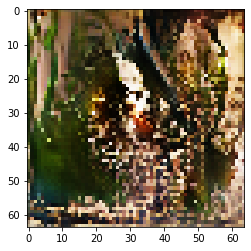

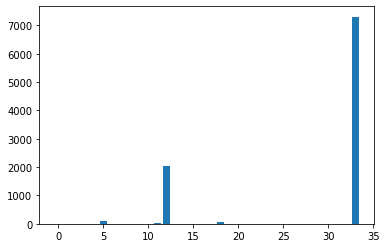

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 6

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 38.06155180931091 sec
Gen loss: 2.681304539445293, Gen valid loss: 1.2286461677331588, Gen attr loss: 1.4526583793040537, Gen caption loss: 1.189514206353888, Disc valid loss: 1.1017697178897496, Disc valid real loss: 0.5724314883310944, Disc valid fake loss: 0.5293382307701318, Disc attr loss: 3.0592459511304613, Disc attr real loss: 1.6065875718264075, Disc attr fake loss: 1.4526583793040537
Time for epoch 2 is 38.45184350013733 sec
Gen loss: 2.684348362248118, Gen valid loss: 1.2346757634222345, Gen attr loss: 1.4496725946260984, Gen caption loss: 1.1896047172184558, Disc valid loss: 1.08965688216977, Disc valid real loss: 0.5670159434884544, Disc valid fake loss: 0.5226409399735572, Disc attr loss: 3.054717117531836, Disc attr real loss: 1.6050445229057375, Disc attr fake loss: 1.4496725946260984
Time for epoch 3 is 38.057746171951294 sec
Gen loss:

Time for epoch 21 is 38.109145402908325 sec
Gen loss: 2.6816803917975283, Gen valid loss: 1.2328871105744588, Gen attr loss: 1.4487932746003314, Gen caption loss: 1.1895513448934891, Disc valid loss: 1.102626313200488, Disc valid real loss: 0.5718084047157267, Disc valid fake loss: 0.5308179101000633, Disc attr loss: 3.0525243314624158, Disc attr real loss: 1.6037310568620842, Disc attr fake loss: 1.4487932746003314
Time for epoch 22 is 38.15721154212952 sec
Gen loss: 2.6729920181801647, Gen valid loss: 1.2234544955941073, Gen attr loss: 1.4495375292087957, Gen caption loss: 1.1895893277514595, Disc valid loss: 1.0951336493013997, Disc valid real loss: 0.565929149062976, Disc valid fake loss: 0.5292045020960211, Disc attr loss: 3.0530356921477693, Disc attr real loss: 1.6034981629389735, Disc attr fake loss: 1.4495375292087957
Time for epoch 23 is 38.12823677062988 sec
Gen loss: 2.678083302851938, Gen valid loss: 1.2301031365627195, Gen attr loss: 1.4479801703274735, Gen caption loss: 

Time for epoch 41 is 38.1338415145874 sec
Gen loss: 2.6830175220158687, Gen valid loss: 1.2339349238853143, Gen attr loss: 1.4490826100837895, Gen caption loss: 1.1892747993714765, Disc valid loss: 1.0958858484498208, Disc valid real loss: 0.5646422971393358, Disc valid fake loss: 0.531243551310485, Disc attr loss: 3.050403798175698, Disc attr real loss: 1.6013211880919087, Disc attr fake loss: 1.4490826100837895
Time for epoch 42 is 38.10334658622742 sec
Gen loss: 2.690428302216982, Gen valid loss: 1.2391464220799082, Gen attr loss: 1.4512818748065772, Gen caption loss: 1.1895679648975692, Disc valid loss: 1.08992469698433, Disc valid real loss: 0.5689013989637215, Disc valid fake loss: 0.5210232963245413, Disc attr loss: 3.0529563362359355, Disc attr real loss: 1.601674461429358, Disc attr fake loss: 1.4512818748065772
Time for epoch 43 is 38.09888935089111 sec
Gen loss: 2.6919135155716565, Gen valid loss: 1.2437736832998632, Gen attr loss: 1.4481398374407595, Gen caption loss: 1.189

Time for epoch 61 is 38.12688231468201 sec
Gen loss: 2.68559123442425, Gen valid loss: 1.2363636976658168, Gen attr loss: 1.4492275304587552, Gen caption loss: 1.189734676019932, Disc valid loss: 1.0945012406281986, Disc valid real loss: 0.5659135265078971, Disc valid fake loss: 0.5285877134741807, Disc attr loss: 3.048751004989231, Disc attr real loss: 1.5995234745304758, Disc attr fake loss: 1.4492275304587552
Time for epoch 62 is 38.13310432434082 sec
Gen loss: 2.6769239333910027, Gen valid loss: 1.227847707303882, Gen attr loss: 1.4490762231795768, Gen caption loss: 1.1896301546717079, Disc valid loss: 1.0950415824163897, Disc valid real loss: 0.5664093949930454, Disc valid fake loss: 0.5286321834658543, Disc attr loss: 3.0501810677329377, Disc attr real loss: 1.6011048445533607, Disc attr fake loss: 1.4490762231795768
Time for epoch 63 is 38.130983114242554 sec
Gen loss: 2.6823402872576625, Gen valid loss: 1.229924587053335, Gen attr loss: 1.4524156814668236, Gen caption loss: 1.1

Time for epoch 81 is 38.13151502609253 sec
Gen loss: 2.6654900431956055, Gen valid loss: 1.218460875798047, Gen attr loss: 1.447029174181827, Gen caption loss: 1.1894385979427555, Disc valid loss: 1.1034912767449045, Disc valid real loss: 0.5721390835314908, Disc valid fake loss: 0.531352193455709, Disc attr loss: 3.0448756641165673, Disc attr real loss: 1.5978464899347404, Disc attr fake loss: 1.447029174181827
Time for epoch 82 is 38.106430768966675 sec
Gen loss: 2.6939864074634667, Gen valid loss: 1.2485502491475444, Gen attr loss: 1.4454361562160296, Gen caption loss: 1.18954569408241, Disc valid loss: 1.0852984899104772, Disc valid real loss: 0.5614384749555975, Disc valid fake loss: 0.5238600161663562, Disc attr loss: 3.0434786210538247, Disc attr real loss: 1.5980424648377953, Disc attr fake loss: 1.4454361562160296
Time for epoch 83 is 38.10359334945679 sec
Gen loss: 2.6827386058766023, Gen valid loss: 1.2319655457163246, Gen attr loss: 1.4507730595141568, Gen caption loss: 1.1

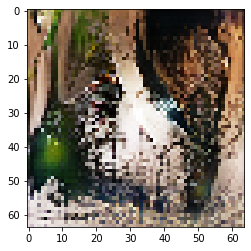

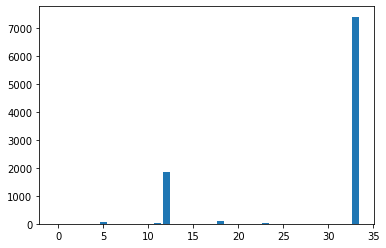

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 7

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 38.099613428115845 sec
Gen loss: 2.680114573579494, Gen valid loss: 1.2286480860658455, Gen attr loss: 1.4514664828292723, Gen caption loss: 1.1897211746794745, Disc valid loss: 1.0971700804343392, Disc valid real loss: 0.5676576421674351, Disc valid fake loss: 0.5295124368131322, Disc attr loss: 3.047562244461804, Disc attr real loss: 1.5960957616325315, Disc attr fake loss: 1.4514664828292723
Time for epoch 2 is 38.137240409851074 sec
Gen loss: 2.688300371816165, Gen valid loss: 1.2377415217035186, Gen attr loss: 1.4505588591583376, Gen caption loss: 1.1896364226896912, Disc valid loss: 1.0911766646031118, Disc valid real loss: 0.5646893831126412, Disc valid fake loss: 0.5264872820558264, Disc attr loss: 3.0472359398839273, Disc attr real loss: 1.5966770807255897, Disc attr fake loss: 1.4505588591583376
Time for epoch 3 is 38.034947633743286 sec
Gen 

Time for epoch 21 is 37.97177171707153 sec
Gen loss: 2.680497968099951, Gen valid loss: 1.2328376081900867, Gen attr loss: 1.447660355063958, Gen caption loss: 1.1895244084399568, Disc valid loss: 1.0947291639439136, Disc valid real loss: 0.5669533766220579, Disc valid fake loss: 0.5277757823144195, Disc attr loss: 3.0431819527452877, Disc attr real loss: 1.5955215976813297, Disc attr fake loss: 1.447660355063958
Time for epoch 22 is 38.00480389595032 sec
Gen loss: 2.6872339746170253, Gen valid loss: 1.2387245299047247, Gen attr loss: 1.448509443743119, Gen caption loss: 1.189399271153499, Disc valid loss: 1.090246140310758, Disc valid real loss: 0.5654484545635338, Disc valid fake loss: 0.5247976857472242, Disc attr loss: 3.043078135668747, Disc attr real loss: 1.5945686919256277, Disc attr fake loss: 1.448509443743119
Time for epoch 23 is 38.0264835357666 sec
Gen loss: 2.6846542048260447, Gen valid loss: 1.2355760591139962, Gen attr loss: 1.4490781440967466, Gen caption loss: 1.18961

Time for epoch 41 is 37.97300100326538 sec
Gen loss: 2.681441430476946, Gen valid loss: 1.2328457375205952, Gen attr loss: 1.4485956811646459, Gen caption loss: 1.1893926905745735, Disc valid loss: 1.0995522214145195, Disc valid real loss: 0.5681556203985602, Disc valid fake loss: 0.5313966027927916, Disc attr loss: 3.0423299226011364, Disc attr real loss: 1.5937342414364906, Disc attr fake loss: 1.4485956811646459
Time for epoch 42 is 38.03335738182068 sec
Gen loss: 2.683232471548768, Gen valid loss: 1.235534844036671, Gen attr loss: 1.447697636234728, Gen caption loss: 1.1896229022886695, Disc valid loss: 1.0917458112646894, Disc valid real loss: 0.5629117798999073, Disc valid fake loss: 0.5288340304763659, Disc attr loss: 3.041210454653918, Disc attr real loss: 1.5935128184191902, Disc attr fake loss: 1.447697636234728
Time for epoch 43 is 38.013136863708496 sec
Gen loss: 2.688845250664688, Gen valid loss: 1.242751841138049, Gen attr loss: 1.446093423902827, Gen caption loss: 1.1896

Time for epoch 61 is 38.03947949409485 sec
Gen loss: 2.6703459499328117, Gen valid loss: 1.219512519313068, Gen attr loss: 1.4508334395039049, Gen caption loss: 1.1894716043782427, Disc valid loss: 1.1075857674203269, Disc valid real loss: 0.5736413060165033, Disc valid fake loss: 0.533944463422951, Disc attr loss: 3.0435933013595537, Disc attr real loss: 1.592759861855649, Disc attr fake loss: 1.4508334395039049
Time for epoch 62 is 37.989593267440796 sec
Gen loss: 2.686921902142243, Gen valid loss: 1.235891320679569, Gen attr loss: 1.4510305796858418, Gen caption loss: 1.1895932073838666, Disc valid loss: 1.0939233794121885, Disc valid real loss: 0.5652398994460015, Disc valid fake loss: 0.5286834788354755, Disc attr loss: 3.0425927277179916, Disc attr real loss: 1.5915621480321496, Disc attr fake loss: 1.4510305796858418
Time for epoch 63 is 37.98740863800049 sec
Gen loss: 2.6904040352115786, Gen valid loss: 1.2430457212737582, Gen attr loss: 1.4473583197529076, Gen caption loss: 1.

Time for epoch 81 is 38.028157234191895 sec
Gen loss: 2.6854110662207047, Gen valid loss: 1.2359259117263441, Gen attr loss: 1.4494851546558907, Gen caption loss: 1.1895314878241479, Disc valid loss: 1.0953200653316528, Disc valid real loss: 0.5658510320070314, Disc valid fake loss: 0.5294690317900846, Disc attr loss: 3.040395270195111, Disc attr real loss: 1.59091011553922, Disc attr fake loss: 1.4494851546558907
Time for epoch 82 is 37.935436725616455 sec
Gen loss: 2.686699059597522, Gen valid loss: 1.2357999742192627, Gen attr loss: 1.450899103469642, Gen caption loss: 1.1895924709676726, Disc valid loss: 1.0945824102011477, Disc valid real loss: 0.5658855833981419, Disc valid fake loss: 0.5286968268030058, Disc attr loss: 3.0420057372995184, Disc attr real loss: 1.5911066338298767, Disc attr fake loss: 1.450899103469642
Time for epoch 83 is 37.8737895488739 sec
Gen loss: 2.6803805272430585, Gen valid loss: 1.2334427248817796, Gen attr loss: 1.4469378185142994, Gen caption loss: 1.1

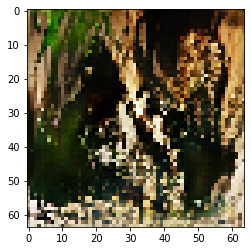

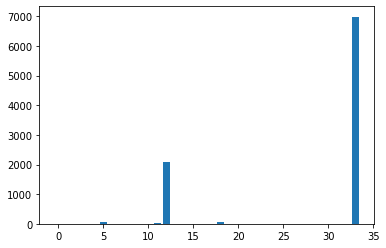

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 8

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 37.831268072128296 sec
Gen loss: 2.665964637022354, Gen valid loss: 1.2196468455681633, Gen attr loss: 1.446317797753869, Gen caption loss: 1.1897575971556873, Disc valid loss: 1.1068099855084406, Disc valid real loss: 0.5753701717711399, Disc valid fake loss: 0.5314398132527101, Disc attr loss: 3.0355761981591947, Disc attr real loss: 1.5892584004053256, Disc attr fake loss: 1.446317797753869
Time for epoch 2 is 37.94375705718994 sec
Gen loss: 2.665704961714706, Gen valid loss: 1.2217171644453757, Gen attr loss: 1.4439877998538133, Gen caption loss: 1.1895176724689762, Disc valid loss: 1.0977883193551041, Disc valid real loss: 0.5681689132842914, Disc valid fake loss: 0.5296194073630542, Disc attr loss: 3.0330240661858867, Disc attr real loss: 1.5890362663320732, Disc attr fake loss: 1.4439877998538133
Time for epoch 3 is 38.08768177032471 sec
Gen los

Time for epoch 21 is 37.966556787490845 sec
Gen loss: 2.696434490079802, Gen valid loss: 1.2486170601392503, Gen attr loss: 1.4478174218640418, Gen caption loss: 1.189443884180167, Disc valid loss: 1.0832895256962556, Disc valid real loss: 0.5601667205331126, Disc valid fake loss: 0.523122808232217, Disc attr loss: 3.0358089082609347, Disc attr real loss: 1.587991486396893, Disc attr fake loss: 1.4478174218640418
Time for epoch 22 is 37.91510891914368 sec
Gen loss: 2.6984300871851645, Gen valid loss: 1.2489578505841696, Gen attr loss: 1.4494722480696391, Gen caption loss: 1.1893606702809734, Disc valid loss: 1.0874381593572415, Disc valid real loss: 0.5627108094330403, Disc valid fake loss: 0.524727352185624, Disc attr loss: 3.0373583392399115, Disc attr real loss: 1.5878860911702721, Disc attr fake loss: 1.4494722480696391
Time for epoch 23 is 37.90890407562256 sec
Gen loss: 2.67617221124127, Gen valid loss: 1.229727861196368, Gen attr loss: 1.4464443505294924, Gen caption loss: 1.189

Time for epoch 41 is 37.79240894317627 sec
Gen loss: 2.6838632624969896, Gen valid loss: 1.2360766113289003, Gen attr loss: 1.4477866503604382, Gen caption loss: 1.1896889012680467, Disc valid loss: 1.10229892346271, Disc valid real loss: 0.5725582974551493, Disc valid fake loss: 0.5297406228577218, Disc attr loss: 3.0358261529023087, Disc attr real loss: 1.5880395025418703, Disc attr fake loss: 1.4477866503604382
Time for epoch 42 is 37.780548095703125 sec
Gen loss: 2.6670289957103366, Gen valid loss: 1.225476326981211, Gen attr loss: 1.4415526684060653, Gen caption loss: 1.1892944096226679, Disc valid loss: 1.097799392088965, Disc valid real loss: 0.5671093107723608, Disc valid fake loss: 0.5306900824473156, Disc attr loss: 3.0290249489187224, Disc attr real loss: 1.5874722805126573, Disc attr fake loss: 1.4415526684060653
Time for epoch 43 is 38.14945197105408 sec
Gen loss: 2.6813638940413145, Gen valid loss: 1.2324266157499173, Gen attr loss: 1.4489372858833167, Gen caption loss: 1

Time for epoch 61 is 37.812583923339844 sec
Gen loss: 2.6748745641734217, Gen valid loss: 1.232698488526228, Gen attr loss: 1.4421760777470864, Gen caption loss: 1.1895532493345782, Disc valid loss: 1.101176794789994, Disc valid real loss: 0.5737250389930032, Disc valid fake loss: 0.5274517576545881, Disc attr loss: 3.032339995469504, Disc attr real loss: 1.5901639177224178, Disc attr fake loss: 1.4421760777470864
Time for epoch 62 is 37.86809945106506 sec
Gen loss: 2.676945311590262, Gen valid loss: 1.2384265716159892, Gen attr loss: 1.4385187354514268, Gen caption loss: 1.1896338688971873, Disc valid loss: 1.0964392426860365, Disc valid real loss: 0.5691029350285931, Disc valid fake loss: 0.527336307334383, Disc attr loss: 3.0271190753797206, Disc attr real loss: 1.5886003399282935, Disc attr fake loss: 1.4385187354514268
Time for epoch 63 is 37.858962059020996 sec
Gen loss: 2.6790568550750815, Gen valid loss: 1.2362286663313868, Gen attr loss: 1.442828197789386, Gen caption loss: 1.

Time for epoch 81 is 37.9172146320343 sec
Gen loss: 2.6632745802240967, Gen valid loss: 1.2375408666243721, Gen attr loss: 1.425733712307483, Gen caption loss: 1.1895460237655535, Disc valid loss: 1.0946784497599615, Disc valid real loss: 0.5678950952805155, Disc valid fake loss: 0.5267833578715803, Disc attr loss: 3.012232073277316, Disc attr real loss: 1.5864983609698329, Disc attr fake loss: 1.425733712307483
Time for epoch 82 is 37.85992908477783 sec
Gen loss: 2.6616197782480295, Gen valid loss: 1.2397341301770715, Gen attr loss: 1.4218856674545826, Gen caption loss: 1.1895654254812535, Disc valid loss: 1.0942687875210109, Disc valid real loss: 0.5687010656527387, Disc valid fake loss: 0.5255677219490372, Disc attr loss: 3.0085491966102826, Disc attr real loss: 1.5866635291557, Disc attr fake loss: 1.4218856674545826
Time for epoch 83 is 37.853435754776 sec
Gen loss: 2.6561667828702022, Gen valid loss: 1.2316725284749577, Gen attr loss: 1.4244942694175533, Gen caption loss: 1.18966

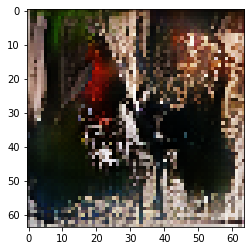

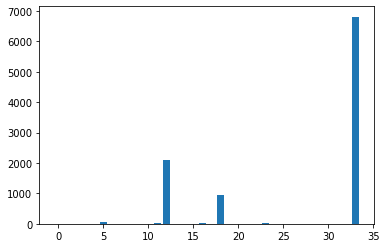

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 9

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 37.72897934913635 sec
Gen loss: 2.6514559851752386, Gen valid loss: 1.2465269670576906, Gen attr loss: 1.404929026032528, Gen caption loss: 1.189765128985976, Disc valid loss: 1.0929719941402838, Disc valid real loss: 0.565426493482538, Disc valid fake loss: 0.5275454968617861, Disc attr loss: 2.9902140690382257, Disc attr real loss: 1.5852850430056977, Disc attr fake loss: 1.404929026032528
Time for epoch 2 is 37.90166354179382 sec
Gen loss: 2.6384280703578216, Gen valid loss: 1.2330390867502063, Gen attr loss: 1.4053889681007157, Gen caption loss: 1.1897970933901263, Disc valid loss: 1.0898223487019216, Disc valid real loss: 0.5658429985446982, Disc valid fake loss: 0.5239793524994114, Disc attr loss: 2.9902141969701463, Disc attr real loss: 1.5848252288694304, Disc attr fake loss: 1.4053889681007157
Time for epoch 3 is 37.81154227256775 sec
Gen loss

Time for epoch 21 is 37.78247547149658 sec
Gen loss: 2.6201340958354917, Gen valid loss: 1.231150231387234, Gen attr loss: 1.3889838554025666, Gen caption loss: 1.189500338985991, Disc valid loss: 1.1043364593007055, Disc valid real loss: 0.572944965385163, Disc valid fake loss: 0.5313914951270189, Disc attr loss: 2.970933057105315, Disc attr real loss: 1.5819492017027486, Disc attr fake loss: 1.3889838554025666
Time for epoch 22 is 37.805999994277954 sec
Gen loss: 2.6307276070602543, Gen valid loss: 1.2401931208323658, Gen attr loss: 1.3905344836434053, Gen caption loss: 1.1895324990032166, Disc valid loss: 1.0889817939864264, Disc valid real loss: 0.5656173943988676, Disc valid fake loss: 0.5233644024951025, Disc attr loss: 2.972595298516395, Disc attr real loss: 1.5820608148729898, Disc attr fake loss: 1.3905344836434053
Time for epoch 23 is 38.0050950050354 sec
Gen loss: 2.6320755869392456, Gen valid loss: 1.2388091155183993, Gen attr loss: 1.393266465605759, Gen caption loss: 1.18

Time for epoch 41 is 37.9712655544281 sec
Gen loss: 2.62195124729539, Gen valid loss: 1.2374912831518385, Gen attr loss: 1.3844599652742628, Gen caption loss: 1.189661673737089, Disc valid loss: 1.101645882213665, Disc valid real loss: 0.5692730287549296, Disc valid fake loss: 0.5323728533779702, Disc attr loss: 2.964612832560449, Disc attr real loss: 1.580152867286186, Disc attr fake loss: 1.3844599652742628
Time for epoch 42 is 37.85578918457031 sec
Gen loss: 2.6263936800039236, Gen valid loss: 1.2408757573220788, Gen attr loss: 1.3855179131515627, Gen caption loss: 1.189453239040323, Disc valid loss: 1.0913422629439087, Disc valid real loss: 0.5668468264544883, Disc valid fake loss: 0.5244954364086555, Disc attr loss: 2.965451345211122, Disc attr real loss: 1.5799334320595595, Disc attr fake loss: 1.3855179131515627
Time for epoch 43 is 37.50463843345642 sec
Gen loss: 2.625753893761777, Gen valid loss: 1.2431937570817426, Gen attr loss: 1.382560126826692, Gen caption loss: 1.1897163

Time for epoch 61 is 37.65554451942444 sec
Gen loss: 2.6210570677832212, Gen valid loss: 1.2458513306408394, Gen attr loss: 1.3752057513570397, Gen caption loss: 1.1894446462796633, Disc valid loss: 1.0903101376078639, Disc valid real loss: 0.5661434643475344, Disc valid fake loss: 0.5241666763294034, Disc attr loss: 2.9515393642875236, Disc attr real loss: 1.576333612930484, Disc attr fake loss: 1.3752057513570397
Time for epoch 62 is 37.78884696960449 sec
Gen loss: 2.6212954049511006, Gen valid loss: 1.2490415321133002, Gen attr loss: 1.3722538670227133, Gen caption loss: 1.1894883518296528, Disc valid loss: 1.0863145386300437, Disc valid real loss: 0.5610861913136996, Disc valid fake loss: 0.5252283479624648, Disc attr loss: 2.9486883575031104, Disc attr real loss: 1.576434490480397, Disc attr fake loss: 1.3722538670227133
Time for epoch 63 is 37.97287344932556 sec
Gen loss: 2.617459297180176, Gen valid loss: 1.2438971372800791, Gen attr loss: 1.3735621531158282, Gen caption loss: 1

Time for epoch 81 is 38.2065691947937 sec
Gen loss: 2.6234314777663728, Gen valid loss: 1.2526789717881015, Gen attr loss: 1.3707524948326877, Gen caption loss: 1.1895370241103134, Disc valid loss: 1.087757081035676, Disc valid real loss: 0.5664201054146619, Disc valid fake loss: 0.5213369712596987, Disc attr loss: 2.9437966149673875, Disc attr real loss: 1.5730441201346999, Disc attr fake loss: 1.3707524948326877
Time for epoch 82 is 37.80891299247742 sec
Gen loss: 2.619387704828567, Gen valid loss: 1.2482263221327206, Gen attr loss: 1.3711613975566255, Gen caption loss: 1.1894684613235598, Disc valid loss: 1.0831224183403056, Disc valid real loss: 0.5575384608290705, Disc valid fake loss: 0.5255839612264297, Disc attr loss: 2.9455888659004272, Disc attr real loss: 1.574427468343802, Disc attr fake loss: 1.3711613975566255
Time for epoch 83 is 37.76443123817444 sec
Gen loss: 2.6056241866372787, Gen valid loss: 1.2370178458813406, Gen attr loss: 1.368606343825012, Gen caption loss: 1.1

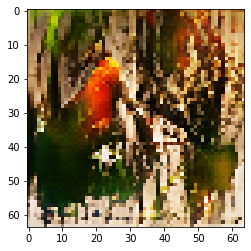

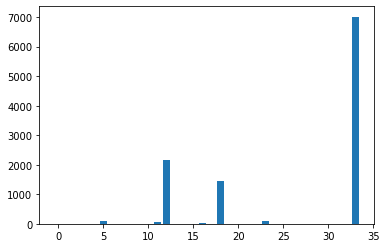

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 10

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 37.66939187049866 sec
Gen loss: 2.6241265616119716, Gen valid loss: 1.2562479816155059, Gen attr loss: 1.367878585973083, Gen caption loss: 1.1895552695928227, Disc valid loss: 1.0817122614480617, Disc valid real loss: 0.5589134453273401, Disc valid fake loss: 0.5227988138592986, Disc attr loss: 2.9386049854723097, Disc attr real loss: 1.5707263994992264, Disc attr fake loss: 1.367878585973083
Time for epoch 2 is 37.9724485874176 sec
Gen loss: 2.626637648760788, Gen valid loss: 1.2602224015608066, Gen attr loss: 1.3664152441309074, Gen caption loss: 1.1896210295075, Disc valid loss: 1.0845114572584467, Disc valid real loss: 0.5554238169335415, Disc valid fake loss: 0.5290876426670933, Disc attr loss: 2.9383806012833347, Disc attr real loss: 1.571965357152427, Disc attr fake loss: 1.3664152441309074
Time for epoch 3 is 37.756115436553955 sec
Gen loss: 

Time for epoch 21 is 37.74639439582825 sec
Gen loss: 2.618825978379909, Gen valid loss: 1.2538473591571901, Gen attr loss: 1.364978642644598, Gen caption loss: 1.1896342404166533, Disc valid loss: 1.085657687691169, Disc valid real loss: 0.5615995844528281, Disc valid fake loss: 0.5240581029152805, Disc attr loss: 2.933914361607415, Disc attr real loss: 1.5689357189628166, Disc attr fake loss: 1.364978642644598
Time for epoch 22 is 37.74609899520874 sec
Gen loss: 2.6126603847596703, Gen valid loss: 1.2534794206541728, Gen attr loss: 1.3591809673361015, Gen caption loss: 1.1897075670521433, Disc valid loss: 1.0816853944525162, Disc valid real loss: 0.558518401006373, Disc valid fake loss: 0.5231669953037407, Disc attr loss: 2.928855471494721, Disc attr real loss: 1.5696745041586195, Disc attr fake loss: 1.3591809673361015
Time for epoch 23 is 37.80308437347412 sec
Gen loss: 2.613313368019373, Gen valid loss: 1.249061331516359, Gen attr loss: 1.3642520355338326, Gen caption loss: 1.18943

Time for epoch 41 is 37.85094618797302 sec
Gen loss: 2.615030452164854, Gen valid loss: 1.254773856340062, Gen attr loss: 1.3602566014783493, Gen caption loss: 1.1894764325159999, Disc valid loss: 1.0891373215652094, Disc valid real loss: 0.562224694545353, Disc valid fake loss: 0.5269126284736282, Disc attr loss: 2.92751943289749, Disc attr real loss: 1.567262831419141, Disc attr fake loss: 1.3602566014783493
Time for epoch 42 is 37.93108248710632 sec
Gen loss: 2.6077607912099783, Gen valid loss: 1.2473246348582632, Gen attr loss: 1.3604361594207888, Gen caption loss: 1.18966522158646, Disc valid loss: 1.0872812998004076, Disc valid real loss: 0.5592011425714829, Disc valid fake loss: 0.5280801557751529, Disc attr loss: 2.927486203227263, Disc attr real loss: 1.567050043806474, Disc attr fake loss: 1.3604361594207888
Time for epoch 43 is 37.59280014038086 sec
Gen loss: 2.602988003392207, Gen valid loss: 1.2368771731045833, Gen attr loss: 1.3661108330336367, Gen caption loss: 1.1896769

Time for epoch 61 is 37.62916111946106 sec
Gen loss: 2.6125828922602543, Gen valid loss: 1.2519320897293609, Gen attr loss: 1.360650810122813, Gen caption loss: 1.189352519466948, Disc valid loss: 1.0904995519617386, Disc valid real loss: 0.5646464445888189, Disc valid fake loss: 0.5258531067267989, Disc attr loss: 2.927066453104097, Disc attr real loss: 1.5664156429812837, Disc attr fake loss: 1.360650810122813
Time for epoch 62 is 37.887585401535034 sec
Gen loss: 2.6007830062855875, Gen valid loss: 1.2435124980078802, Gen attr loss: 1.3572705134466734, Gen caption loss: 1.1896363186642407, Disc valid loss: 1.0875718546753654, Disc valid real loss: 0.5634158546847057, Disc valid fake loss: 0.524155998698418, Disc attr loss: 2.9233769110547816, Disc attr real loss: 1.5661063976081082, Disc attr fake loss: 1.3572705134466734
Time for epoch 63 is 37.59805417060852 sec
Gen loss: 2.603454841830866, Gen valid loss: 1.2436186306198762, Gen attr loss: 1.3598362010345872, Gen caption loss: 1.1

Time for epoch 81 is 37.782917976379395 sec
Gen loss: 2.6083859932131883, Gen valid loss: 1.2505894582769088, Gen attr loss: 1.3577965501201186, Gen caption loss: 1.1897158764888278, Disc valid loss: 1.0891548810289482, Disc valid real loss: 0.5669882084296002, Disc valid fake loss: 0.5221666722762875, Disc attr loss: 2.92238615069609, Disc attr real loss: 1.5645896005759716, Disc attr fake loss: 1.3577965501201186
Time for epoch 82 is 37.71822786331177 sec
Gen loss: 2.6040226715367014, Gen valid loss: 1.2478722760347816, Gen attr loss: 1.3561503871023493, Gen caption loss: 1.1895265307852891, Disc valid loss: 1.0931792621043963, Disc valid real loss: 0.5666630857682163, Disc valid fake loss: 0.5265161741555222, Disc attr loss: 2.920267240464849, Disc attr real loss: 1.5641168533624996, Disc attr fake loss: 1.3561503871023493
Time for epoch 83 is 37.70686173439026 sec
Gen loss: 2.5998755690205066, Gen valid loss: 1.244591387468302, Gen attr loss: 1.35528418591352, Gen caption loss: 1.1

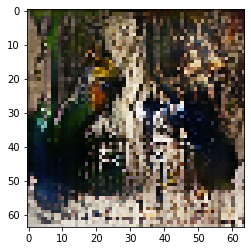

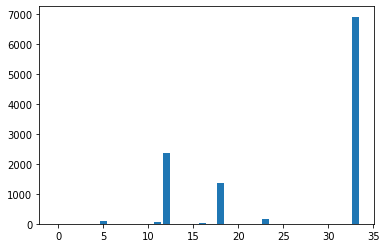

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 11

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 37.65664076805115 sec
Gen loss: 2.5921472159181507, Gen valid loss: 1.2376304335064359, Gen attr loss: 1.3545167743352047, Gen caption loss: 1.1895494561208295, Disc valid loss: 1.0951429760553004, Disc valid real loss: 0.5655925410388285, Disc valid fake loss: 0.5295504358241229, Disc attr loss: 2.9182519663963213, Disc attr real loss: 1.5637351920611167, Disc attr fake loss: 1.3545167743352047
Time for epoch 2 is 37.56225919723511 sec
Gen loss: 2.5886656191290878, Gen valid loss: 1.2374709513452318, Gen attr loss: 1.351194671822111, Gen caption loss: 1.1897894454196216, Disc valid loss: 1.0933586073115589, Disc valid real loss: 0.5663805428720748, Disc valid fake loss: 0.5269780636318331, Disc attr loss: 2.9147716534493093, Disc attr real loss: 1.563576981627198, Disc attr fake loss: 1.351194671822111
Time for epoch 3 is 37.970805168151855 sec
Gen l

Time for epoch 21 is 37.70478272438049 sec
Gen loss: 2.593462547312584, Gen valid loss: 1.24119924384404, Gen attr loss: 1.3522632936152017, Gen caption loss: 1.1896545454092464, Disc valid loss: 1.0967791258158077, Disc valid real loss: 0.5656496934128324, Disc valid fake loss: 0.5311294327260356, Disc attr loss: 2.914340492509568, Disc attr real loss: 1.5620771988943662, Disc attr fake loss: 1.3522632936152017
Time for epoch 22 is 37.71466517448425 sec
Gen loss: 2.605387216014914, Gen valid loss: 1.2494360922474848, Gen attr loss: 1.3559511308747578, Gen caption loss: 1.1895914080989394, Disc valid loss: 1.0895772747554107, Disc valid real loss: 0.5644603857826088, Disc valid fake loss: 0.5251168878420904, Disc attr loss: 2.9174628377283813, Disc attr real loss: 1.5615117068536237, Disc attr fake loss: 1.3559511308747578
Time for epoch 23 is 37.66142201423645 sec
Gen loss: 2.5811529553679593, Gen valid loss: 1.2287855736285367, Gen attr loss: 1.352367386908389, Gen caption loss: 1.18

Time for epoch 41 is 37.721251487731934 sec
Gen loss: 2.5961308847597944, Gen valid loss: 1.241877153313903, Gen attr loss: 1.3542537433991264, Gen caption loss: 1.1894564105243217, Disc valid loss: 1.09814732927617, Disc valid real loss: 0.5676283778213873, Disc valid fake loss: 0.5305189497587157, Disc attr loss: 2.9149580059981925, Disc attr real loss: 1.5607042625990664, Disc attr fake loss: 1.3542537433991264
Time for epoch 42 is 37.548410415649414 sec
Gen loss: 2.5906382492241176, Gen valid loss: 1.236403802384529, Gen attr loss: 1.3542344579851724, Gen caption loss: 1.1897016250021089, Disc valid loss: 1.0931437357977476, Disc valid real loss: 0.5625409325610008, Disc valid fake loss: 0.530602799360022, Disc attr loss: 2.9153034948721164, Disc attr real loss: 1.561069036886944, Disc attr fake loss: 1.3542344579851724
Time for epoch 43 is 37.74396777153015 sec
Gen loss: 2.6092185017862293, Gen valid loss: 1.253641204297704, Gen attr loss: 1.3555772937733306, Gen caption loss: 1.1

Time for epoch 61 is 37.71217370033264 sec
Gen loss: 2.589757411460566, Gen valid loss: 1.238937198954223, Gen attr loss: 1.3508202260748803, Gen caption loss: 1.1896112792214082, Disc valid loss: 1.0966136048479778, Disc valid real loss: 0.5637212923064141, Disc valid fake loss: 0.5328923153683423, Disc attr loss: 2.9107428149479193, Disc attr real loss: 1.5599225888730388, Disc attr fake loss: 1.3508202260748803
Time for epoch 62 is 37.60220503807068 sec
Gen loss: 2.5907891442782187, Gen valid loss: 1.2379427632988307, Gen attr loss: 1.3528463859868243, Gen caption loss: 1.1894253358285278, Disc valid loss: 1.0945614616722272, Disc valid real loss: 0.5642913619515696, Disc valid fake loss: 0.5302701028704966, Disc attr loss: 2.912507048790371, Disc attr real loss: 1.5596606628035465, Disc attr fake loss: 1.3528463859868243
Time for epoch 63 is 37.62951469421387 sec
Gen loss: 2.5863511374972377, Gen valid loss: 1.2364333544966328, Gen attr loss: 1.3499177746010345, Gen caption loss: 1

Time for epoch 81 is 37.5911078453064 sec
Gen loss: 2.589817076194577, Gen valid loss: 1.2360277476349497, Gen attr loss: 1.353789326621265, Gen caption loss: 1.1896310256425604, Disc valid loss: 1.1009554942125874, Disc valid real loss: 0.5704567209491885, Disc valid fake loss: 0.5304987710827411, Disc attr loss: 2.91164663329034, Disc attr real loss: 1.557857306669075, Disc attr fake loss: 1.353789326621265
Time for epoch 82 is 37.62404751777649 sec
Gen loss: 2.589642896884825, Gen valid loss: 1.239416256022001, Gen attr loss: 1.3502266387629316, Gen caption loss: 1.1896832599872496, Disc valid loss: 1.0926035605471955, Disc valid real loss: 0.5648007201470011, Disc valid fake loss: 0.5278028407232548, Disc attr loss: 2.9072973133748787, Disc attr real loss: 1.5570706746119471, Disc attr fake loss: 1.3502266387629316
Time for epoch 83 is 37.5569224357605 sec
Gen loss: 2.60280949184242, Gen valid loss: 1.2487008122570793, Gen attr loss: 1.3541086837851257, Gen caption loss: 1.18967310

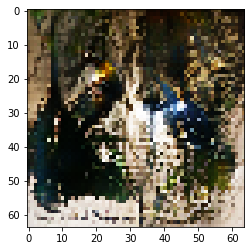

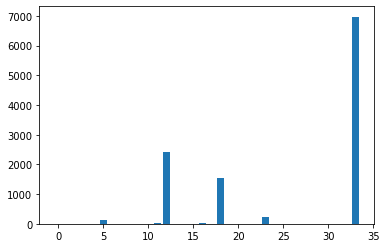

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 12

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 37.486103773117065 sec
Gen loss: 2.595584240063096, Gen valid loss: 1.2425273125410725, Gen attr loss: 1.3530569234837684, Gen caption loss: 1.1894370467682196, Disc valid loss: 1.1001297269410235, Disc valid real loss: 0.5684662755265791, Disc valid fake loss: 0.5316634507683234, Disc attr loss: 2.909983832984759, Disc attr real loss: 1.5569269095009906, Disc attr fake loss: 1.3530569234837684
Time for epoch 2 is 37.67402768135071 sec
Gen loss: 2.5964696988826845, Gen valid loss: 1.2447220350345622, Gen attr loss: 1.351747657225384, Gen caption loss: 1.1895701642928085, Disc valid loss: 1.0900042199183932, Disc valid real loss: 0.561742390882032, Disc valid fake loss: 0.5282618270979987, Disc attr loss: 2.9080488772250126, Disc attr real loss: 1.5563012199996287, Disc attr fake loss: 1.351747657225384
Time for epoch 3 is 37.64412307739258 sec
Gen los

Time for epoch 21 is 37.650853872299194 sec
Gen loss: 2.5912980044760356, Gen valid loss: 1.2396051906311738, Gen attr loss: 1.351692799630204, Gen caption loss: 1.189703125940752, Disc valid loss: 1.100362610364671, Disc valid real loss: 0.5707127729728616, Disc valid fake loss: 0.5296498373918094, Disc attr loss: 2.9067354977615483, Disc attr real loss: 1.555042698131344, Disc attr fake loss: 1.351692799630204
Time for epoch 22 is 37.59479331970215 sec
Gen loss: 2.5914305813590364, Gen valid loss: 1.2388259472885752, Gen attr loss: 1.3526046256708906, Gen caption loss: 1.18956850763905, Disc valid loss: 1.0931171488955738, Disc valid real loss: 0.5656628252529516, Disc valid fake loss: 0.5274543247733335, Disc attr loss: 2.907920493019952, Disc attr real loss: 1.5553158673490612, Disc attr fake loss: 1.3526046256708906
Time for epoch 23 is 37.58622145652771 sec
Gen loss: 2.593549045443858, Gen valid loss: 1.24193866433813, Gen attr loss: 1.3516103798134864, Gen caption loss: 1.189389

Time for epoch 41 is 37.61165761947632 sec
Gen loss: 2.5893014950480886, Gen valid loss: 1.2419202807472973, Gen attr loss: 1.3473812222157713, Gen caption loss: 1.1897824107792965, Disc valid loss: 1.0972643497836623, Disc valid real loss: 0.5654577780868303, Disc valid fake loss: 0.5318065704045903, Disc attr loss: 2.9013987417789657, Disc attr real loss: 1.5540175195631942, Disc attr fake loss: 1.3473812222157713
Time for epoch 42 is 37.639238357543945 sec
Gen loss: 2.5873910075603783, Gen valid loss: 1.2372296114924155, Gen attr loss: 1.3501614002677482, Gen caption loss: 1.1893988088540592, Disc valid loss: 1.0953609229426398, Disc valid real loss: 0.5607541789853476, Disc valid fake loss: 0.534606742261225, Disc attr loss: 2.9028953682116376, Disc attr real loss: 1.5527339679438894, Disc attr fake loss: 1.3501614002677482
Time for epoch 43 is 37.662495374679565 sec
Gen loss: 2.5924741860004623, Gen valid loss: 1.241915279287633, Gen attr loss: 1.3505589147893393, Gen caption loss

Time for epoch 61 is 37.55717658996582 sec
Gen loss: 2.602612090304615, Gen valid loss: 1.2527600263515462, Gen attr loss: 1.3498520634684783, Gen caption loss: 1.1895266845620422, Disc valid loss: 1.0956203147647827, Disc valid real loss: 0.5648268597720438, Disc valid fake loss: 0.5307934560426851, Disc attr loss: 2.9024709941248905, Disc attr real loss: 1.5526189306564124, Disc attr fake loss: 1.3498520634684783
Time for epoch 62 is 37.658103227615356 sec
Gen loss: 2.5823379344733426, Gen valid loss: 1.2358616516195984, Gen attr loss: 1.346476274777234, Gen caption loss: 1.189385460321173, Disc valid loss: 1.100270014952838, Disc valid real loss: 0.5718681326080467, Disc valid fake loss: 0.5284018814563751, Disc attr loss: 2.8993828597107556, Disc attr real loss: 1.5529065849335213, Disc attr fake loss: 1.346476274777234
Time for epoch 63 is 37.578670024871826 sec
Gen loss: 2.593930438282044, Gen valid loss: 1.2401189222568418, Gen attr loss: 1.3538115124715375, Gen caption loss: 1.

Time for epoch 81 is 37.824328899383545 sec
Gen loss: 2.5968513301394496, Gen valid loss: 1.2494228322331498, Gen attr loss: 1.3474285046905683, Gen caption loss: 1.1896036036292388, Disc valid loss: 1.0918185715752888, Disc valid real loss: 0.5585011994935632, Disc valid fake loss: 0.5333173749892692, Disc attr loss: 2.8987341931841883, Disc attr real loss: 1.55130568849362, Disc attr fake loss: 1.3474285046905683
Time for epoch 82 is 37.68738627433777 sec
Gen loss: 2.5861629612723664, Gen valid loss: 1.2372349641187403, Gen attr loss: 1.3489280141142972, Gen caption loss: 1.1893709332639286, Disc valid loss: 1.1034504024963068, Disc valid real loss: 0.5721523873205108, Disc valid fake loss: 0.5312980176795142, Disc attr loss: 2.9004862806015224, Disc attr real loss: 1.551558266487225, Disc attr fake loss: 1.3489280141142972
Time for epoch 83 is 37.71190881729126 sec
Gen loss: 2.5873287648043335, Gen valid loss: 1.2352898815459998, Gen attr loss: 1.352038861936347, Gen caption loss: 1

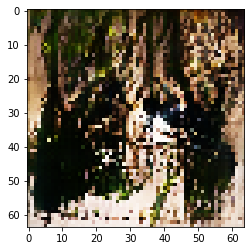

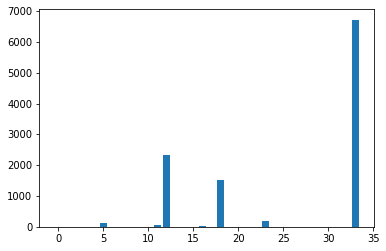

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 13

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 37.62285566329956 sec
Gen loss: 2.5803619199975074, Gen valid loss: 1.231883895914083, Gen attr loss: 1.3484780184298673, Gen caption loss: 1.1895810889034737, Disc valid loss: 1.097678829983967, Disc valid real loss: 0.5680570123479941, Disc valid fake loss: 0.5296218165052615, Disc attr loss: 2.8984010448946864, Disc attr real loss: 1.549923026464819, Disc attr fake loss: 1.3484780184298673
Time for epoch 2 is 37.68415331840515 sec
Gen loss: 2.5849229178131434, Gen valid loss: 1.2338001613371417, Gen attr loss: 1.3511227634218004, Gen caption loss: 1.1894364256845904, Disc valid loss: 1.0988138371366796, Disc valid real loss: 0.5667021461134034, Disc valid fake loss: 0.5321116898925646, Disc attr loss: 2.9010146148805696, Disc attr real loss: 1.5498918514587692, Disc attr fake loss: 1.3511227634218004
Time for epoch 3 is 37.62171697616577 sec
Gen lo

Time for epoch 21 is 37.61492443084717 sec
Gen loss: 2.5975861988739593, Gen valid loss: 1.2465372434476527, Gen attr loss: 1.3510489476728569, Gen caption loss: 1.1897746510298917, Disc valid loss: 1.0935505964568637, Disc valid real loss: 0.5659994308541461, Disc valid fake loss: 0.527551165925778, Disc attr loss: 2.899614666212542, Disc attr real loss: 1.548565718539685, Disc attr fake loss: 1.3510489476728569
Time for epoch 22 is 37.641387701034546 sec
Gen loss: 2.593845372600607, Gen valid loss: 1.2447793296359095, Gen attr loss: 1.3490660387649123, Gen caption loss: 1.1895682579133569, Disc valid loss: 1.0889678427843543, Disc valid real loss: 0.5579852789721191, Disc valid fake loss: 0.5309825650237117, Disc attr loss: 2.8969986706891357, Disc attr real loss: 1.5479326319242235, Disc attr fake loss: 1.3490660387649123
Time for epoch 23 is 37.94791507720947 sec
Gen loss: 2.5867531945711875, Gen valid loss: 1.2378542751154602, Gen attr loss: 1.3488989125099287, Gen caption loss: 1

Time for epoch 41 is 37.71868371963501 sec
Gen loss: 2.577164161496046, Gen valid loss: 1.22993936948983, Gen attr loss: 1.347224790229384, Gen caption loss: 1.1893274897159276, Disc valid loss: 1.1108451264337473, Disc valid real loss: 0.5762259245403414, Disc valid fake loss: 0.5346191997935132, Disc attr loss: 2.894790062413306, Disc attr real loss: 1.5475652721839221, Disc attr fake loss: 1.347224790229384
Time for epoch 42 is 37.76509976387024 sec
Gen loss: 2.569620852224872, Gen valid loss: 1.2206844362786147, Gen attr loss: 1.3489364085158682, Gen caption loss: 1.189652616092506, Disc valid loss: 1.1017865296301803, Disc valid real loss: 0.5673907662471782, Disc valid fake loss: 0.534395763302237, Disc attr loss: 2.8959937699765046, Disc attr real loss: 1.5470573614606367, Disc attr fake loss: 1.3489364085158682
Time for epoch 43 is 37.707263469696045 sec
Gen loss: 2.5972249081464316, Gen valid loss: 1.2480299253127762, Gen attr loss: 1.3491949802491723, Gen caption loss: 1.1896

Time for epoch 61 is 37.76753354072571 sec
Gen loss: 2.550711646635681, Gen valid loss: 1.2579576610549679, Gen attr loss: 1.2927539649048472, Gen caption loss: 1.1896904496965692, Disc valid loss: 1.0913523110916945, Disc valid real loss: 0.5627313988803202, Disc valid fake loss: 0.5286209149573876, Disc attr loss: 2.817512892126068, Disc attr real loss: 1.5247589272212208, Disc attr fake loss: 1.2927539649048472
Time for epoch 62 is 37.69243240356445 sec
Gen loss: 2.5344870704299387, Gen valid loss: 1.2501682338675832, Gen attr loss: 1.284318828001255, Gen caption loss: 1.1894863270485627, Disc valid loss: 1.089544636285725, Disc valid real loss: 0.561985514351346, Disc valid fake loss: 0.5275591205613723, Disc attr loss: 2.807244989607069, Disc attr real loss: 1.5229261616058143, Disc attr fake loss: 1.284318828001255
Time for epoch 63 is 37.72933602333069 sec
Gen loss: 2.5303669298890483, Gen valid loss: 1.2485641714357103, Gen attr loss: 1.2818027616839422, Gen caption loss: 1.189

Time for epoch 81 is 37.76778554916382 sec
Gen loss: 2.4962489837553443, Gen valid loss: 1.2296916819846404, Gen attr loss: 1.266557307424261, Gen caption loss: 1.1894239458611342, Disc valid loss: 1.105922282549747, Disc valid real loss: 0.5684236120079268, Disc valid fake loss: 0.5374986681996322, Disc attr loss: 2.7660014383838107, Disc attr real loss: 1.4994441309595496, Disc attr fake loss: 1.266557307424261
Time for epoch 82 is 37.75558066368103 sec
Gen loss: 2.5202192982360923, Gen valid loss: 1.256707491913462, Gen attr loss: 1.2635118019613147, Gen caption loss: 1.189463896480033, Disc valid loss: 1.085140440845231, Disc valid real loss: 0.560666078878289, Disc valid fake loss: 0.5244743655206066, Disc attr loss: 2.7633006370810635, Disc attr real loss: 1.4997888351197488, Disc attr fake loss: 1.2635118019613147
Time for epoch 83 is 37.811989307403564 sec
Gen loss: 2.5181365336182964, Gen valid loss: 1.2507811190313116, Gen attr loss: 1.267355401987629, Gen caption loss: 1.189

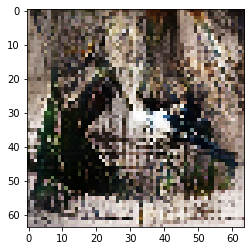

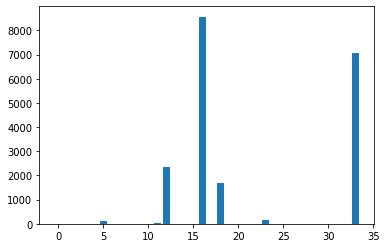

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 14

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 37.93470549583435 sec
Gen loss: 2.493554457093319, Gen valid loss: 1.2393040369519697, Gen attr loss: 1.2542504180414566, Gen caption loss: 1.1895216070216523, Disc valid loss: 1.101300256039069, Disc valid real loss: 0.567322370401889, Disc valid fake loss: 0.5339778836988175, Disc attr loss: 2.743193079301012, Disc attr real loss: 1.4889426612595555, Disc attr fake loss: 1.2542504180414566
Time for epoch 2 is 37.77493071556091 sec
Gen loss: 2.512619186546098, Gen valid loss: 1.2554149049407421, Gen attr loss: 1.257204287097383, Gen caption loss: 1.1893803025002725, Disc valid loss: 1.0853009127019866, Disc valid real loss: 0.5598848977386144, Disc valid fake loss: 0.5254160117327682, Disc attr loss: 2.7455949201816465, Disc attr real loss: 1.4883906330842636, Disc attr fake loss: 1.257204287097383
Time for epoch 3 is 37.799163579940796 sec
Gen loss:

Time for epoch 21 is 37.93597722053528 sec
Gen loss: 2.49919180430694, Gen valid loss: 1.2503605982475487, Gen attr loss: 1.2488312096130558, Gen caption loss: 1.1896903458326489, Disc valid loss: 1.0893510400764341, Disc valid real loss: 0.5585175415041647, Disc valid fake loss: 0.5308335001875715, Disc attr loss: 2.730363884753974, Disc attr real loss: 1.4815326751409184, Disc attr fake loss: 1.2488312096130558
Time for epoch 22 is 38.03609085083008 sec
Gen loss: 2.5082743872148883, Gen valid loss: 1.2562931451371047, Gen attr loss: 1.2519812548386695, Gen caption loss: 1.1897361160616888, Disc valid loss: 1.0884126205108353, Disc valid real loss: 0.5650421112048917, Disc valid fake loss: 0.5233705097905342, Disc attr loss: 2.7341971965986214, Disc attr real loss: 1.482215941759952, Disc attr fake loss: 1.2519812548386695
Time for epoch 23 is 38.11206793785095 sec
Gen loss: 2.5100672904068864, Gen valid loss: 1.25455243186899, Gen attr loss: 1.255514844161708, Gen caption loss: 1.189

Time for epoch 41 is 38.08538579940796 sec
Gen loss: 2.5013887862849042, Gen valid loss: 1.2559794507375577, Gen attr loss: 1.2454093381318296, Gen caption loss: 1.1895655745736307, Disc valid loss: 1.094701130538775, Disc valid real loss: 0.5624291450189058, Disc valid fake loss: 0.5322719843083927, Disc attr loss: 2.722426370553531, Disc attr real loss: 1.4770170324217013, Disc attr fake loss: 1.2454093381318296
Time for epoch 42 is 38.02777814865112 sec
Gen loss: 2.5132220456916787, Gen valid loss: 1.2652638349429701, Gen attr loss: 1.247958210102588, Gen caption loss: 1.1894373993886518, Disc valid loss: 1.0831063391393438, Disc valid real loss: 0.5606415708698231, Disc valid fake loss: 0.5224647711770645, Disc attr loss: 2.7243402146388522, Disc attr real loss: 1.4763820045362643, Disc attr fake loss: 1.247958210102588
Time for epoch 43 is 38.073731660842896 sec
Gen loss: 2.4957601142123464, Gen valid loss: 1.2496235672697464, Gen attr loss: 1.246136550334734, Gen caption loss: 1.

Time for epoch 61 is 38.07178020477295 sec
Gen loss: 2.5021152884010376, Gen valid loss: 1.2588163276674948, Gen attr loss: 1.2432989554030462, Gen caption loss: 1.1896587340489313, Disc valid loss: 1.0839949225991723, Disc valid real loss: 0.5609824119544611, Disc valid fake loss: 0.5230125072525769, Disc attr loss: 2.7161256895478827, Disc attr real loss: 1.4728267341448362, Disc attr fake loss: 1.2432989554030462
Time for epoch 62 is 38.220836877822876 sec
Gen loss: 2.4865345609220384, Gen valid loss: 1.2450340264211825, Gen attr loss: 1.2415005256166949, Gen caption loss: 1.1893738477533748, Disc valid loss: 1.0981937903698866, Disc valid real loss: 0.5683341270216759, Disc valid fake loss: 0.5298596641558618, Disc attr loss: 2.713738479588413, Disc attr real loss: 1.472237953971718, Disc attr fake loss: 1.2415005256166949
Time for epoch 63 is 38.234739780426025 sec
Gen loss: 2.4758108360011404, Gen valid loss: 1.2318416354132862, Gen attr loss: 1.2439691934805253, Gen caption loss

Time for epoch 81 is 38.21905517578125 sec
Gen loss: 2.500542777017526, Gen valid loss: 1.2632992740892137, Gen attr loss: 1.2372434917827286, Gen caption loss: 1.1896441008663436, Disc valid loss: 1.0871152695278488, Disc valid real loss: 0.5591928819976848, Disc valid fake loss: 0.5279223887416405, Disc attr loss: 2.706287701924642, Disc attr real loss: 1.4690442101419134, Disc attr fake loss: 1.2372434917827286
Time for epoch 82 is 37.89917755126953 sec
Gen loss: 2.497492141516874, Gen valid loss: 1.2549400639727832, Gen attr loss: 1.242552087235903, Gen caption loss: 1.189650319456085, Disc valid loss: 1.0880680853112281, Disc valid real loss: 0.5624248189170186, Disc valid fake loss: 0.525643265263498, Disc attr loss: 2.711206892318519, Disc attr real loss: 1.4686548050826158, Disc attr fake loss: 1.242552087235903
Time for epoch 83 is 38.12101078033447 sec
Gen loss: 2.487410726909069, Gen valid loss: 1.246432365602271, Gen attr loss: 1.240978359045375, Gen caption loss: 1.1894310

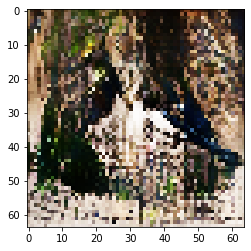

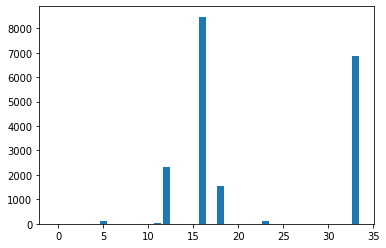

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 15

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 38.06818652153015 sec
Gen loss: 2.4887952714108517, Gen valid loss: 1.2475998162577147, Gen attr loss: 1.2411954483688685, Gen caption loss: 1.1896699456987665, Disc valid loss: 1.0931292945130409, Disc valid real loss: 0.5619429361206406, Disc valid fake loss: 0.5311863607345881, Disc attr loss: 2.7085016707417764, Disc attr real loss: 1.4673062223729079, Disc attr fake loss: 1.2411954483688685
Time for epoch 2 is 38.21884489059448 sec
Gen loss: 2.5011400026357595, Gen valid loss: 1.2635364834532181, Gen attr loss: 1.2376035403429977, Gen caption loss: 1.1896362611594884, Disc valid loss: 1.0830440201410434, Disc valid real loss: 0.5580302854863609, Disc valid fake loss: 0.5250137330393804, Disc attr loss: 2.7051510058121306, Disc attr real loss: 1.467547465469133, Disc attr fake loss: 1.2376035403429977
Time for epoch 3 is 38.27046799659729 sec
Gen 

Time for epoch 21 is 38.23317003250122 sec
Gen loss: 2.4816505540677203, Gen valid loss: 1.246194641764571, Gen attr loss: 1.2354559071341826, Gen caption loss: 1.189498959195, Disc valid loss: 1.0960720530370387, Disc valid real loss: 0.564674629913113, Disc valid fake loss: 0.5313974243354022, Disc attr loss: 2.698582887003415, Disc attr real loss: 1.4631269798692326, Disc attr fake loss: 1.2354559071341826
Time for epoch 22 is 38.24077296257019 sec
Gen loss: 2.4723684645603665, Gen valid loss: 1.2382631319648205, Gen attr loss: 1.2341053464871434, Gen caption loss: 1.189486545598927, Disc valid loss: 1.0983064408870893, Disc valid real loss: 0.567309151093165, Disc valid fake loss: 0.5309972899554545, Disc attr loss: 2.6977976623589432, Disc attr real loss: 1.4636923158717996, Disc attr fake loss: 1.2341053464871434
Time for epoch 23 is 38.207709550857544 sec
Gen loss: 2.476858520895485, Gen valid loss: 1.2414226709665646, Gen attr loss: 1.2354358523518736, Gen caption loss: 1.18976

Time for epoch 41 is 38.37455201148987 sec
Gen loss: 2.482401918266524, Gen valid loss: 1.2535850576915069, Gen attr loss: 1.2288168599288962, Gen caption loss: 1.189549135967968, Disc valid loss: 1.0870369760001577, Disc valid real loss: 0.5563538887797979, Disc valid fake loss: 0.5306830858473532, Disc attr loss: 2.6904389766173633, Disc attr real loss: 1.4616221166884673, Disc attr fake loss: 1.2288168599288962
Time for epoch 42 is 38.35855770111084 sec
Gen loss: 2.4980613623208145, Gen valid loss: 1.2682619417909038, Gen attr loss: 1.2297994303832531, Gen caption loss: 1.189584498482991, Disc valid loss: 1.0868836647772853, Disc valid real loss: 0.5623794177844919, Disc valid fake loss: 0.5245042420661223, Disc attr loss: 2.6915712913846583, Disc attr real loss: 1.461771861001405, Disc attr fake loss: 1.2297994303832531
Time for epoch 43 is 38.388646364212036 sec
Gen loss: 2.4800646899515373, Gen valid loss: 1.250240265838499, Gen attr loss: 1.2298244192671324, Gen caption loss: 1.

Time for epoch 61 is 38.42628884315491 sec
Gen loss: 2.4875232753391834, Gen valid loss: 1.2538045520381875, Gen attr loss: 1.2337187299237342, Gen caption loss: 1.1896123252910005, Disc valid loss: 1.0954155797557779, Disc valid real loss: 0.5648693573184129, Disc valid fake loss: 0.5305462230027207, Disc attr loss: 2.6915722209909743, Disc attr real loss: 1.4578534910672403, Disc attr fake loss: 1.2337187299237342
Time for epoch 62 is 38.495826959609985 sec
Gen loss: 2.483544372607699, Gen valid loss: 1.255313851322908, Gen attr loss: 1.2282305187003075, Gen caption loss: 1.1897597493841072, Disc valid loss: 1.0875982264193094, Disc valid real loss: 0.5597449373100508, Disc valid fake loss: 0.5278532909668558, Disc attr loss: 2.685626918061316, Disc attr real loss: 1.4573963993610082, Disc attr fake loss: 1.2282305187003075
Time for epoch 63 is 38.5121386051178 sec
Gen loss: 2.489421917171013, Gen valid loss: 1.259793351174693, Gen attr loss: 1.229628554850736, Gen caption loss: 1.18

Time for epoch 81 is 38.498518228530884 sec
Gen loss: 2.474019802682768, Gen valid loss: 1.246738937812123, Gen attr loss: 1.2272808569556652, Gen caption loss: 1.1895237960789584, Disc valid loss: 1.0925341527959518, Disc valid real loss: 0.5583696922635645, Disc valid fake loss: 0.5341644596439713, Disc attr loss: 2.6819632348975513, Disc attr real loss: 1.4546823779418863, Disc attr fake loss: 1.2272808569556652
Time for epoch 82 is 38.43623375892639 sec
Gen loss: 2.48611388426163, Gen valid loss: 1.2567627268431956, Gen attr loss: 1.2293511650103541, Gen caption loss: 1.1896671247353077, Disc valid loss: 1.0882280578781274, Disc valid real loss: 0.5608431487710173, Disc valid fake loss: 0.5273849120954188, Disc attr loss: 2.683530693293264, Disc attr real loss: 1.4541795282829098, Disc attr fake loss: 1.2293511650103541
Time for epoch 83 is 38.464033126831055 sec
Gen loss: 2.4864954315226897, Gen valid loss: 1.253677771020388, Gen attr loss: 1.232817658887, Gen caption loss: 1.1895

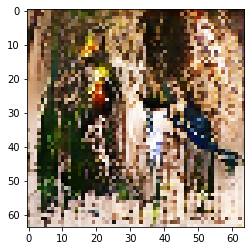

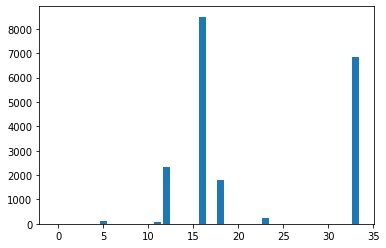

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 16

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 38.2609920501709 sec
Gen loss: 2.4703918356236403, Gen valid loss: 1.2467824435492518, Gen attr loss: 1.223609392397449, Gen caption loss: 1.1894099562148737, Disc valid loss: 1.0920501814948187, Disc valid real loss: 0.5649316618597604, Disc valid fake loss: 0.5271185227848973, Disc attr loss: 2.6753548036422834, Disc attr real loss: 1.4517454112448342, Disc attr fake loss: 1.223609392397449
Time for epoch 2 is 38.462363719940186 sec
Gen loss: 2.4864480230543347, Gen valid loss: 1.2598773932392358, Gen attr loss: 1.2265706483910723, Gen caption loss: 1.189533141893423, Disc valid loss: 1.089859003620096, Disc valid real loss: 0.5597899285596883, Disc valid fake loss: 0.5300690782910117, Disc attr loss: 2.677739355137678, Disc attr real loss: 1.4511687067466053, Disc attr fake loss: 1.2265706483910723
Time for epoch 3 is 38.51446080207825 sec
Gen loss

Time for epoch 21 is 38.180617809295654 sec
Gen loss: 2.481160526353169, Gen valid loss: 1.2526481729858936, Gen attr loss: 1.228512355305638, Gen caption loss: 1.1896593641782518, Disc valid loss: 1.0904399321331242, Disc valid real loss: 0.5613429972795936, Disc valid fake loss: 0.5290969342074097, Disc attr loss: 2.678828997663689, Disc attr real loss: 1.4503166423580511, Disc attr fake loss: 1.228512355305638
Time for epoch 22 is 38.20220470428467 sec
Gen loss: 2.472674645705598, Gen valid loss: 1.2483147436041173, Gen attr loss: 1.2243598970940444, Gen caption loss: 1.1893880662879324, Disc valid loss: 1.0922836381891556, Disc valid real loss: 0.564401154595662, Disc valid fake loss: 0.5278824816551312, Disc attr loss: 2.6743130031316906, Disc attr real loss: 1.4499531060376465, Disc attr fake loss: 1.2243598970940444
Time for epoch 23 is 38.06364727020264 sec
Gen loss: 2.4835388498900706, Gen valid loss: 1.2592715414235909, Gen attr loss: 1.224267307820359, Gen caption loss: 1.18

Time for epoch 41 is 38.104607820510864 sec
Gen loss: 2.484265180784189, Gen valid loss: 1.2526233537087272, Gen attr loss: 1.231641826106281, Gen caption loss: 1.1895231842025509, Disc valid loss: 1.0930453710116668, Disc valid real loss: 0.5640885622359226, Disc valid fake loss: 0.5289568099064555, Disc attr loss: 2.6802134628541423, Disc attr real loss: 1.4485716367478616, Disc attr fake loss: 1.231641826106281
Time for epoch 42 is 37.840014934539795 sec
Gen loss: 2.4796130883338328, Gen valid loss: 1.254209779788485, Gen attr loss: 1.2254033093529988, Gen caption loss: 1.189709841720457, Disc valid loss: 1.0931429371924257, Disc valid real loss: 0.5638751940837075, Disc valid fake loss: 0.5292677409280606, Disc attr loss: 2.674461109043783, Disc attr real loss: 1.449057799690784, Disc attr fake loss: 1.2254033093529988
Time for epoch 43 is 38.35944938659668 sec
Gen loss: 2.4692364546664685, Gen valid loss: 1.2444536912085886, Gen attr loss: 1.224782762811759, Gen caption loss: 1.18

Time for epoch 61 is 37.955169439315796 sec
Gen loss: 2.467787864731579, Gen valid loss: 1.2476102291406979, Gen attr loss: 1.2201776323602775, Gen caption loss: 1.189680716694209, Disc valid loss: 1.0960730462862547, Disc valid real loss: 0.5625147924513675, Disc valid fake loss: 0.5335582535925919, Disc attr loss: 2.6676140593965525, Disc attr real loss: 1.447436427036275, Disc attr fake loss: 1.2201776323602775
Time for epoch 62 is 38.10625171661377 sec
Gen loss: 2.4821561804308803, Gen valid loss: 1.2615569468113141, Gen attr loss: 1.2205992308735525, Gen caption loss: 1.1894121182966362, Disc valid loss: 1.086318328451658, Disc valid real loss: 0.5603578195662356, Disc valid fake loss: 0.5259605113083754, Disc attr loss: 2.667093324628949, Disc attr real loss: 1.4464940937553965, Disc attr fake loss: 1.2205992308735525
Time for epoch 63 is 38.253968954086304 sec
Gen loss: 2.4801816636630836, Gen valid loss: 1.255973851131553, Gen attr loss: 1.224207815923665, Gen caption loss: 1.1

Time for epoch 81 is 38.061906576156616 sec
Gen loss: 2.470422760903997, Gen valid loss: 1.2473812918999008, Gen attr loss: 1.2230414547894382, Gen caption loss: 1.1896421805952946, Disc valid loss: 1.095360927303955, Disc valid real loss: 0.565775249950931, Disc valid fake loss: 0.529585679614447, Disc attr loss: 2.667572252634095, Disc attr real loss: 1.4445307978446567, Disc attr fake loss: 1.2230414547894382
Time for epoch 82 is 38.0606210231781 sec
Gen loss: 2.478455232410896, Gen valid loss: 1.2583352902394322, Gen attr loss: 1.2201199515402155, Gen caption loss: 1.189549196703324, Disc valid loss: 1.0865643084210754, Disc valid real loss: 0.5586054616665775, Disc valid fake loss: 0.5279588487736255, Disc attr loss: 2.6642762719777218, Disc attr real loss: 1.4441563204375063, Disc attr fake loss: 1.2201199515402155
Time for epoch 83 is 38.04401397705078 sec
Gen loss: 2.483480425708016, Gen valid loss: 1.2620665464943988, Gen attr loss: 1.2214138898746107, Gen caption loss: 1.1894

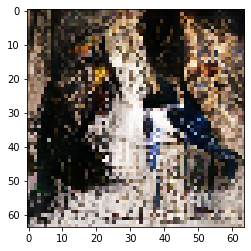

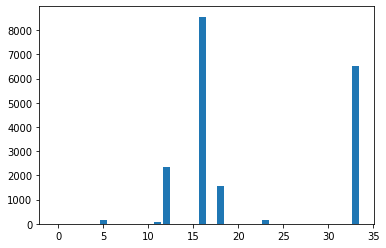

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 17

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 38.03187918663025 sec
Gen loss: 2.47564990604473, Gen valid loss: 1.2548034879250256, Gen attr loss: 1.2208464165044024, Gen caption loss: 1.189422718877715, Disc valid loss: 1.0936113297131649, Disc valid real loss: 0.5609819064456919, Disc valid fake loss: 0.5326294225405871, Disc attr loss: 2.662769732759574, Disc attr real loss: 1.4419233162551714, Disc attr fake loss: 1.2208464165044024
Time for epoch 2 is 38.002915143966675 sec
Gen loss: 2.468308507588498, Gen valid loss: 1.2478501220059588, Gen attr loss: 1.22045838655172, Gen caption loss: 1.1895949042586453, Disc valid loss: 1.0885700819292043, Disc valid real loss: 0.5614834616016243, Disc valid fake loss: 0.5270866191968685, Disc attr loss: 2.662816253942526, Disc attr real loss: 1.4423578673908057, Disc attr fake loss: 1.22045838655172
Time for epoch 3 is 38.16550827026367 sec
Gen loss: 2.

Time for epoch 21 is 37.931811809539795 sec
Gen loss: 2.488750075260152, Gen valid loss: 1.2638077826357792, Gen attr loss: 1.22494229843946, Gen caption loss: 1.1896067398996535, Disc valid loss: 1.091265925062381, Disc valid real loss: 0.5633322020694815, Disc valid fake loss: 0.5279337187123493, Disc attr loss: 2.6656771549364415, Disc attr real loss: 1.4407348564969815, Disc attr fake loss: 1.22494229843946
Time for epoch 22 is 38.01201677322388 sec
Gen loss: 2.4808204080354233, Gen valid loss: 1.2579908648803628, Gen attr loss: 1.2228295303941743, Gen caption loss: 1.1895524434603972, Disc valid loss: 1.0856306766106831, Disc valid real loss: 0.5559626872623517, Disc valid fake loss: 0.5296679886214455, Disc attr loss: 2.663431799024101, Disc attr real loss: 1.440602268629927, Disc attr fake loss: 1.2228295303941743
Time for epoch 23 is 38.00256276130676 sec
Gen loss: 2.469695735430007, Gen valid loss: 1.245894827493807, Gen attr loss: 1.2238009148819984, Gen caption loss: 1.18978

Time for epoch 41 is 37.99699544906616 sec
Gen loss: 2.4673869916740148, Gen valid loss: 1.249595940436128, Gen attr loss: 1.2177910528531888, Gen caption loss: 1.1896329882345225, Disc valid loss: 1.1003178485686862, Disc valid real loss: 0.5627731507225089, Disc valid fake loss: 0.5375447025305533, Disc attr loss: 2.656327261349696, Disc attr real loss: 1.4385362084965072, Disc attr fake loss: 1.2177910528531888
Time for epoch 42 is 37.96742558479309 sec
Gen loss: 2.472555081049601, Gen valid loss: 1.2483804810660963, Gen attr loss: 1.224174598691263, Gen caption loss: 1.1896221371200997, Disc valid loss: 1.0909900674975015, Disc valid real loss: 0.56047715921066, Disc valid fake loss: 0.5305129078830161, Disc attr loss: 2.663108443180074, Disc attr real loss: 1.4389338444888107, Disc attr fake loss: 1.224174598691263
Time for epoch 43 is 37.94183301925659 sec
Gen loss: 2.480345591620055, Gen valid loss: 1.2620685903360527, Gen attr loss: 1.218276981254257, Gen caption loss: 1.189430

Time for epoch 61 is 37.9550359249115 sec
Gen loss: 2.4720137303437646, Gen valid loss: 1.2552724096187085, Gen attr loss: 1.2167413302553378, Gen caption loss: 1.189353635317588, Disc valid loss: 1.0948878100247887, Disc valid real loss: 0.5632883319202154, Disc valid fake loss: 0.5315994785083988, Disc attr loss: 2.653505681006889, Disc attr real loss: 1.4367643507515513, Disc attr fake loss: 1.2167413302553378
Time for epoch 62 is 37.96027636528015 sec
Gen loss: 2.4710308491052975, Gen valid loss: 1.2524516172202298, Gen attr loss: 1.2185792205779533, Gen caption loss: 1.189359796402577, Disc valid loss: 1.0877834235426533, Disc valid real loss: 0.5602205108174787, Disc valid fake loss: 0.5275629117559935, Disc attr loss: 2.6550592600814693, Disc attr real loss: 1.4364800395035162, Disc attr fake loss: 1.2185792205779533
Time for epoch 63 is 38.028847217559814 sec
Gen loss: 2.478411814061607, Gen valid loss: 1.256222675647839, Gen attr loss: 1.2221891288834859, Gen caption loss: 1.1

Time for epoch 81 is 37.985751152038574 sec
Gen loss: 2.4812288471676793, Gen valid loss: 1.264590215230699, Gen attr loss: 1.2166386327446315, Gen caption loss: 1.1896805646942883, Disc valid loss: 1.0918090091488226, Disc valid real loss: 0.5632197242280655, Disc valid fake loss: 0.5285892858899383, Disc attr loss: 2.6519564491946523, Disc attr real loss: 1.4353178164500209, Disc attr fake loss: 1.2166386327446315
Time for epoch 82 is 38.11632299423218 sec
Gen loss: 2.4679253107810086, Gen valid loss: 1.2494757595424084, Gen attr loss: 1.2184495573767478, Gen caption loss: 1.1896741916816733, Disc valid loss: 1.0888882733295926, Disc valid real loss: 0.5558901413830961, Disc valid fake loss: 0.5329981296850737, Disc attr loss: 2.653474298596059, Disc attr real loss: 1.4350247412193111, Disc attr fake loss: 1.2184495573767478
Time for epoch 83 is 38.09300947189331 sec
Gen loss: 2.47265565233825, Gen valid loss: 1.254608006173679, Gen attr loss: 1.218047650041296, Gen caption loss: 1.1

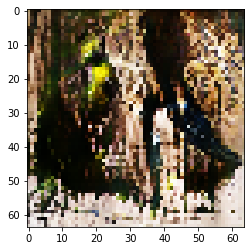

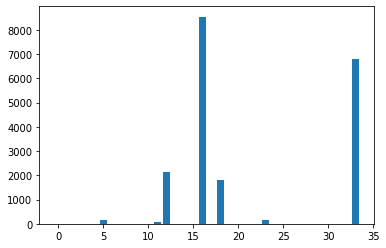

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 18

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 38.10485506057739 sec
Gen loss: 2.483205560100111, Gen valid loss: 1.2653974629029996, Gen attr loss: 1.2178081010738362, Gen caption loss: 1.1897412486838777, Disc valid loss: 1.0870964859882344, Disc valid real loss: 0.5598093638736704, Disc valid fake loss: 0.5272871200146714, Disc attr loss: 2.650934405604675, Disc attr real loss: 1.433126304530839, Disc attr fake loss: 1.2178081010738362
Time for epoch 2 is 37.96682834625244 sec
Gen loss: 2.479401267964019, Gen valid loss: 1.260523920459799, Gen attr loss: 1.2188773447582069, Gen caption loss: 1.1895766956050222, Disc valid loss: 1.0889670918304422, Disc valid real loss: 0.5597986010355032, Disc valid fake loss: 0.5291684901488183, Disc attr loss: 2.651845623645679, Disc attr real loss: 1.4329682788874722, Disc attr fake loss: 1.2188773447582069
Time for epoch 3 is 38.21198081970215 sec
Gen loss:

Time for epoch 21 is 38.04805517196655 sec
Gen loss: 2.474764989320502, Gen valid loss: 1.256000455802049, Gen attr loss: 1.2187645399796607, Gen caption loss: 1.1896741506530017, Disc valid loss: 1.0912327653347316, Disc valid real loss: 0.5622570944349294, Disc valid fake loss: 0.528975668396084, Disc attr loss: 2.649765091536814, Disc attr real loss: 1.431000551557153, Disc attr fake loss: 1.2187645399796607
Time for epoch 22 is 38.06863236427307 sec
Gen loss: 2.4702673365430132, Gen valid loss: 1.2523472275191205, Gen attr loss: 1.2179201087008324, Gen caption loss: 1.1897189287635368, Disc valid loss: 1.091931658385569, Disc valid real loss: 0.5603455710540296, Disc valid fake loss: 0.53158608797766, Disc attr loss: 2.6490580581714145, Disc attr real loss: 1.431137949470582, Disc attr fake loss: 1.2179201087008324
Time for epoch 23 is 38.124550342559814 sec
Gen loss: 2.482597585616073, Gen valid loss: 1.2622641140852517, Gen attr loss: 1.2203334710462306, Gen caption loss: 1.18969

Time for epoch 41 is 38.21694326400757 sec
Gen loss: 2.467043716409988, Gen valid loss: 1.2503670565481109, Gen attr loss: 1.2166766676153271, Gen caption loss: 1.1895809196198213, Disc valid loss: 1.0989791057943328, Disc valid real loss: 0.5689605766034062, Disc valid fake loss: 0.5300185295139871, Disc attr loss: 2.64588208234084, Disc attr real loss: 1.429205414725513, Disc attr fake loss: 1.2166766676153271
Time for epoch 42 is 38.24657320976257 sec
Gen loss: 2.46712469666954, Gen valid loss: 1.2503708400700473, Gen attr loss: 1.2167538616069287, Gen caption loss: 1.189509628587945, Disc valid loss: 1.0928516988831807, Disc valid real loss: 0.5635371190422596, Disc valid fake loss: 0.5293145808101023, Disc attr loss: 2.6457859712241465, Disc attr real loss: 1.4290321096172178, Disc attr fake loss: 1.2167538616069287
Time for epoch 43 is 38.021652936935425 sec
Gen loss: 2.4778856552713284, Gen valid loss: 1.2581291147040803, Gen attr loss: 1.2197565407287785, Gen caption loss: 1.18

Time for epoch 61 is 38.057047605514526 sec
Gen loss: 2.4690598969860127, Gen valid loss: 1.254193626929751, Gen attr loss: 1.2148662782943023, Gen caption loss: 1.1895273684809202, Disc valid loss: 1.0943095168770167, Disc valid real loss: 0.5668022480760486, Disc valid fake loss: 0.527507267912552, Disc attr loss: 2.6430679094500658, Disc attr real loss: 1.4282016311557635, Disc attr fake loss: 1.2148662782943023
Time for epoch 62 is 38.04143238067627 sec
Gen loss: 2.478953192873699, Gen valid loss: 1.2629353014757316, Gen attr loss: 1.216017895274692, Gen caption loss: 1.1894833156409947, Disc valid loss: 1.0858794625212507, Disc valid real loss: 0.5611002899120817, Disc valid fake loss: 0.5247791737398804, Disc attr loss: 2.644185753049566, Disc attr real loss: 1.428167857774874, Disc attr fake loss: 1.216017895274692
Time for epoch 63 is 38.03439784049988 sec
Gen loss: 2.4704533993067135, Gen valid loss: 1.2553444768032085, Gen attr loss: 1.2151089163653572, Gen caption loss: 1.18

Time for epoch 81 is 38.0486261844635 sec
Gen loss: 2.4760103199863175, Gen valid loss: 1.2587078591672385, Gen attr loss: 1.2173024598498978, Gen caption loss: 1.1897116317981626, Disc valid loss: 1.0949047645579186, Disc valid real loss: 0.5617902517964847, Disc valid fake loss: 0.5331145152651521, Disc attr loss: 2.643405596576732, Disc attr real loss: 1.4261031367268342, Disc attr fake loss: 1.2173024598498978
Time for epoch 82 is 38.04066491127014 sec
Gen loss: 2.459790977359141, Gen valid loss: 1.242850206893311, Gen attr loss: 1.216940766266045, Gen caption loss: 1.1893619475002857, Disc valid loss: 1.092299860505877, Disc valid real loss: 0.5589307284129021, Disc valid fake loss: 0.5333691302353774, Disc attr loss: 2.643185092020164, Disc attr real loss: 1.426244325754119, Disc attr fake loss: 1.216940766266045
Time for epoch 83 is 38.02877187728882 sec
Gen loss: 2.451574774615487, Gen valid loss: 1.2403866123700853, Gen attr loss: 1.211188169837321, Gen caption loss: 1.1895157

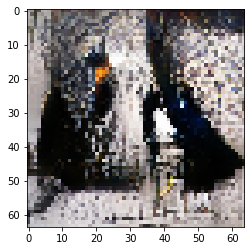

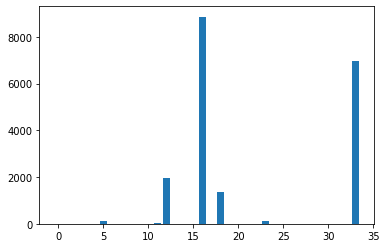

In [242]:
next_starting_checkpoint, totalepochs, warmup = long_train(starting_checkpoint=next_starting_checkpoint, 
                                      num_checkpoints=19, 
                                      checkpoint_interval=100, 
                                      g_hist=gen_loss_hist, 
                                      g_valid_hist=gen_valid_loss_hist,
                                      g_attr_hist=gen_attr_loss_hist,
                                      g_caption_hist=gen_caption_loss_hist,
                                      d_hist=disc_loss_hist,
                                      d_real_hist=disc_loss_real_hist,
                                      d_fake_hist=disc_loss_fake_hist,
                                      d_attr_real_hist=disc_attr_loss_real_hist,
                                      d_attr_fake_hist=disc_attr_loss_fake_hist,
                                      noise=noise300,
                                      caption=caption,
                                      save_files=True,
                                      warmup=warmup,
                                      weights=train_attr_weights)

In [73]:
generator.load_weights('./results/weights/bird-gan-attributes-split-captions-concat-caption-loss-autoencoder-34-weighted/gen_weights_attributes_split_1900.h5')
discriminator_attr.load_weights('./results/weights/bird-gan-attributes-split-captions-concat-caption-loss-autoencoder-34-weighted/disc_weights_attributes_split_attr_1900.h5')

In [74]:
np.sqrt(train_attr_weights / np.min(train_attr_weights)) 

array([ 2.8468995,  1.4311652,  5.176872 ,  7.844145 ,  5.5751657,
        1.3153982,  1.842626 ,  3.4284668,  5.1314597,  8.575347 ,
        3.7019649,  1.199642 ,  1.3278395,  3.620593 ,  1.6323617,
        3.7711668,  1.       ,  5.3585715,  1.6139243,  1.4651524,
        4.682657 ,  5.3972616,  6.78458  ,  2.887949 , 11.093296 ,
        2.705173 ,  3.1942208,  2.8565145,  2.7857885,  4.0645475,
        3.1834657,  4.340939 ,  3.6444392,  1.0251287], dtype=float32)

In [438]:
def weight_scaling(x):
    return x * tf.constant(np.sqrt(train_attr_weights / np.min(train_attr_weights)))

def make_new_generator_model(shape):
    
    noise_in = Input(shape=shape)
    captions_in = Input(shape=(1024,))
    
    c = encoder(captions_in)
    
    c = Lambda(weight_scaling)(c)
    
    input_layer = concatenate([noise_in, c])
    
    x = Dense(16*16*64*2)(input_layer)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Reshape((16, 16, 128))(x)
    
    x = GaussianNoise(1)(x)
    x = Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = GaussianNoise(1)(x)
    x = Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = GaussianNoise(1)(x)
    x = Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = GaussianNoise(1)(x)
    x = Conv2DTranspose(64, (5, 5), strides=(1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(3, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh')(x)
    
    return Model([noise_in, captions_in], [x, c])

new_generator = make_new_generator_model(300)

In [439]:
g = 4
ng = 5
for i in range(len(generator.layers[4:])):
    new_generator.layers[ng].set_weights(generator.layers[g].get_weights())
    g += 1 
    ng += 1

In [ ]:
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(10., 10.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(3, 3),  # creates 2x2 grid of axes
                 axes_pad=1.2,  # pad between axes in inch.
                 )

indices = np.random.choice(len(train_captions), 9)
captions = train_captions[indices]
text = [caption_text[x] for x in indices]
tempnoise = np.random.normal(0, 1, 300)
for i, ax in enumerate(grid):
    generated = new_generator.predict([np.array([tempnoise]), np.array([55. * captions[i]])] )
    generated_image = generated[0][0]
    generated_attrs = generated[1][0]
    ax.imshow(unnormalize_img(generated_image))
    ax.set_title('\n'.join(wrap(text[i], 35)))
    print(np.where(np.round(generated_attrs) >= 1))

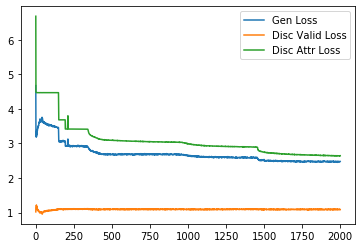

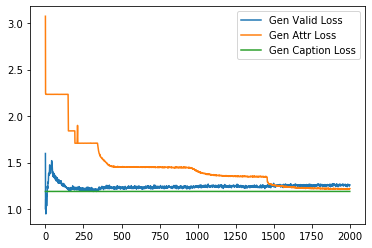

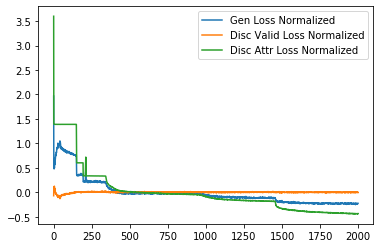

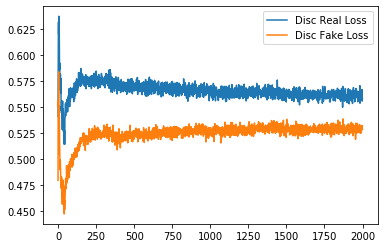

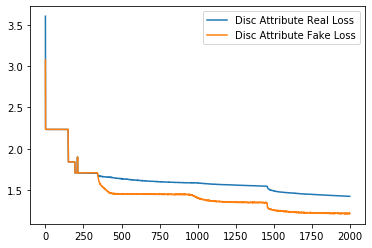

In [243]:
plot_save_dir = 'bird-gan-attributes-split-captions-concat-caption-loss-autoencoder-34-weighted'

from operator import add
disc_attr_loss_hist = list( map(add, disc_attr_loss_real_hist, disc_attr_loss_fake_hist) )

plt.plot(gen_loss_hist)
plt.plot(disc_loss_hist)
plt.plot(disc_attr_loss_hist)

plt.legend(['Gen Loss','Disc Valid Loss', 'Disc Attr Loss'])
plt.savefig('./results/plots/'+plot_save_dir+'/g_d_losses.png')
plt.show()

plt.plot(gen_valid_loss_hist)
plt.plot(gen_attr_loss_hist)
plt.plot(gen_caption_loss_hist)
plt.legend(['Gen Valid Loss', 'Gen Attr Loss', 'Gen Caption Loss'])
plt.savefig('./results/plots/'+plot_save_dir+'/g_valid_attr_losses.png')
plt.show()

plt.plot(gen_loss_hist - np.mean(gen_loss_hist))
plt.plot(disc_loss_hist - np.mean(disc_loss_hist))
plt.plot(disc_attr_loss_hist - np.mean(disc_attr_loss_hist))
plt.legend(['Gen Loss Normalized','Disc Valid Loss Normalized', 'Disc Attr Loss Normalized'])
plt.savefig('./results/plots/'+plot_save_dir+'/g_d_losses_normalized.png')
plt.show()

plt.plot(disc_loss_real_hist)
plt.plot(disc_loss_fake_hist)
plt.legend(['Disc Real Loss','Disc Fake Loss'])
plt.savefig('./results/plots/'+plot_save_dir+'/d_real_fake_losses.png')
plt.show()

plt.plot(disc_attr_loss_real_hist)
# plt.show()
plt.plot(disc_attr_loss_fake_hist)
plt.legend(['Disc Attribute Real Loss', 'Disc Attribute Fake Loss'])
plt.savefig('./results/plots/'+plot_save_dir+'/d_attribute_real_fake_losses.png')
plt.show()


In [ ]:
prediction = discriminator_attr.predict(np.array([train_imgs[6]]))[0]
print(np.where(np.round(prediction) == 1))

In [ ]:
prediction = discriminator_attr.predict(np.array([train_imgs[344]]))[0]
print(np.where(np.round(prediction) == 1))

In [ ]:
d = dict.fromkeys([i for i in range(10)], 0)
prediction = discriminator_attr.predict(np.array(train_imgs))
prediction = np.round(prediction)
for p in prediction:
    p = np.where(p == 1)
    for i in p[0]:
        d[i] += 1
    
# for im in train_imgs:
#     for p in prediction[0]:
#         d[p] += 1

In [ ]:
plt.bar([x for x in range(10)], d.values())

In [ ]:
plt.bar([x for x in range(10)], np.sum(train_attrs, axis=0))

In [ ]:
train_captions[0]

In [ ]:
from bert_serving.client import BertClient
bc = BertClient()

In [ ]:
testcaption = bc.encode(['red bird.'])[0]

In [ ]:
testcaption[0][0]


In [58]:
def save_plots(epochs):
    plt.ioff()
    plot_save_dir = 'bird-gan-attributes-split-captions-concat-caption-loss-autoencoder-34'

    from operator import add
    disc_attr_loss_hist = list( map(add, disc_attr_loss_real_hist, disc_attr_loss_fake_hist) )
    
    fig = plt.figure()
    plt.plot(gen_loss_hist)
    plt.plot(disc_loss_hist)
    plt.plot(disc_attr_loss_hist)

    plt.legend(['Gen Loss','Disc Valid Loss', 'Disc Attr Loss'])
    plt.savefig('./results/plots/'+plot_save_dir+'/g_d_losses' + str(epochs) + '.png')
    plt.close(fig)
#     plt.show()

    fig = plt.figure()
    plt.plot(gen_valid_loss_hist)
    plt.plot(gen_attr_loss_hist)
    plt.plot(gen_caption_loss_hist)
    plt.legend(['Gen Valid Loss', 'Gen Attr Loss', 'Gen Caption Loss'])
    plt.savefig('./results/plots/'+plot_save_dir+'/g_valid_attr_losses' + str(epochs) + '.png')
    plt.close(fig)
#     plt.show()

    fig = plt.figure()
    plt.plot(gen_loss_hist - np.mean(gen_loss_hist))
    plt.plot(disc_loss_hist - np.mean(disc_loss_hist))
    plt.plot(disc_attr_loss_hist - np.mean(disc_attr_loss_hist))
    plt.legend(['Gen Loss Normalized','Disc Valid Loss Normalized', 'Disc Attr Loss Normalized'])
    plt.savefig('./results/plots/'+plot_save_dir+'/g_d_losses_normalized' + str(epochs) + '.png')
    plt.close(fig)
#     plt.show()

    fig = plt.figure()
    plt.plot(disc_loss_real_hist)
    plt.plot(disc_loss_fake_hist)
    plt.legend(['Disc Real Loss','Disc Fake Loss'])
    plt.savefig('./results/plots/'+plot_save_dir+'/d_real_fake_losses' + str(epochs) + '.png')
    plt.close(fig)
#     plt.show()

    fig = plt.figure()
    plt.plot(disc_attr_loss_real_hist)
    # plt.show()
    plt.plot(disc_attr_loss_fake_hist)
    plt.legend(['Disc Attribute Real Loss', 'Disc Attribute Fake Loss'])
    plt.savefig('./results/plots/'+plot_save_dir+'/d_attribute_real_fake_losses' + str(epochs) + '.png')
    plt.close(fig)
#     plt.show()
    plt.ion()

In [561]:
# generator.load_weights('./results/weights/bird-gan-attributes-split-captions-concat-caption-loss-autoencoder-34/gen_weights_attributes_split_2000.h5')

# del train_imgs

fid_imgs = []
import os
for root, dirs, files in os.walk("./CUB_200_2011/CUB_200_2011/images-cleaned/", topdown=False):
    for name in files:
        im = cv2.cvtColor(cv2.imread(os.path.join(root, name)), cv2.COLOR_RGB2BGR)
        im = cv2.resize(im, (299, 299))
        fid_imgs.append(im)

fid_imgs = np.array(fid_imgs)
fid_imgs = fid_imgs[5894:]
# fid_imgs = (fid_imgs - 127.5)/127.5

train_captions = train_captions[5894:]

def generate_fake_images(model, samples, noise_dim):
    noise = np.random.normal(0, 1, (samples, noise_dim))
    imgs = model.predict([noise, train_captions])[0]
    resized_imgs = []
    for img in imgs:
        resized_imgs.append(cv2.resize(unnormalize_img(img), (299, 299)))
    return np.round(255*np.array(resized_imgs))


from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
iv3 = InceptionV3(include_top=False, pooling='avg')#, input_shape=(75,75,3))

import scipy

# calculate frechet inception distance
def calculate_fid(model, images1, images2):
    images1 = preprocess_input(images1)
    images2 = preprocess_input(images2)
    act1 = model.predict(images1)
    act2 = model.predict(images2)
    # calculate mean and covariance statistics
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    # calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2)**2.0)
    # calculate sqrt of product between cov
    covmean = scipy.linalg.sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    # calculate score
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

fids = 0
for i in range(1):
    fake_images = generate_fake_images(new_generator, len(fid_imgs), 300)
    fids += calculate_fid(iv3, fid_imgs, fake_images)
    print(f'{100*(i+1)/5.:.2f}%')
print(fids/1.)

20.00%
63.351549975637845


In [563]:
(60.63816385224977 + 63.351549975637845) / 2

61.994856913943806

In [560]:
train_captions

array([[-0.18826514, -0.23472328, -0.12803595, ...,  0.12800913,
         0.02513238,  0.19851945],
       [-0.17825212, -0.43948334, -0.04086634, ...,  0.15317403,
        -0.01451942,  0.06955066],
       [-0.62160933, -0.21012507, -0.27649984, ...,  0.12463799,
         0.14263171, -0.06853861],
       ...,
       [-0.45454457, -0.18677379, -0.27029344, ...,  0.07825997,
         0.12721159,  0.24787791],
       [-0.45298126, -0.27879766, -0.08860286, ...,  0.4313587 ,
         0.23620032,  0.01515426],
       [-0.3130513 , -0.3545295 , -0.05443699, ...,  0.10745987,
         0.07421204,  0.12210634]], dtype=float32)

<BarContainer object of 34 artists>

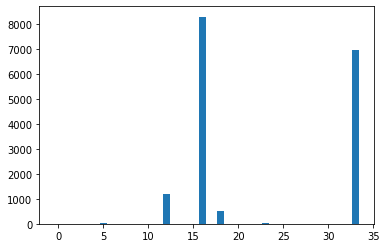

In [476]:
# discriminator_attr.load_weights('./results/weights/bird-gan-attributes-split-captions-concat-caption-loss-autoencoder-34/disc_weights_attributes_split_attr_6000.h5')

d = dict.fromkeys([i for i in range(34)], 0)
prediction = discriminator_attr.predict(np.array(train_imgs))
# prediction = tf.math.sigmoid(prediction)
for p in prediction:
    p = np.where(p == 1)
    for i in p[0]:
        d[i] += 1
    
plt.bar([x for x in range(34)], d.values())

In [78]:
np.min(prediction)

0.00023075016